# **Homework 1: Compustat and its Perils**
### Applied Corporate Finance - FINA6223A.H2026
### Prof. Jakub Hajda
### Team : Nguyen-Bao Michael Hoang, Philippe Theriault et Nguyen Quoc-Long Tran
## **Importation of packages**

In [86]:
import pandas as pd
import numpy as np
import linearmodels as lm
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections as ct
from pandas.plotting import scatter_matrix
import seaborn as sns

## **Data preparation**

In [87]:
# Load the dataset
df = pd.read_csv('HW0.csv')
df = df[(df["fyear"] >= 1995) & (df["fyear"] <= 2020)] # Filter years between 1995 and 2020 inclusive
df.head()

,costat,curcd,datafmt,indfmt,consol,tic,datadate,gvkey,conm,loc,...,ebit,ni,oibdp,sale,xint,capx,dv,prstkc,csho,prcc_f
1,A,USD,STD,INDL,C,AIR,1996-05-31,1004,AAR CORP,USA,...,32.442,16.012,42.557,504.990,10.616,7.547,7.676,1.552,15.998,22.124999
2,A,USD,STD,INDL,C,AIR,1997-05-31,1004,AAR CORP,USA,...,42.890,23.025,55.177,589.328,10.786,30.292,7.976,8.080,18.204,30.999985
3,A,USD,STD,INDL,C,AIR,1998-05-31,1004,AAR CORP,USA,...,64.716,35.657,78.999,782.123,14.494,17.495,9.118,0.000,27.704,26.437500
4,A,USD,STD,INDL,C,AIR,1999-05-31,1004,AAR CORP,USA,...,77.381,41.671,94.444,918.036,18.567,36.131,9.375,7.558,27.381,19.750000
5,A,USD,STD,INDL,C,AIR,2000-05-31,1004,AAR CORP,USA,...,70.658,35.163,89.031,1024.333,23.431,22.344,9.218,10.530,26.865,13.875000


The HW0.csv file corresponds to the dataset downloaded from WRDS and contains all the variables required to compute the financial ratios listed in Table 1, as instructed. In addition to these variables, we included the fiscal year variable (fyear), which was not explicitly mentioned in the instructions. This variable was added to facilitate the identification and removal of duplicate firm–year observations.
The resulting dataset contains a total of 32 variables. Furthermore, since the assignment focuses on the period from 1995 to 2020, we explicitly restrict the sample to fiscal years within this range during the data preparation stage. This ensures that all observations used in the analysis correspond to complete fiscal years within the required sample window.


## **1. Understanding Data Issues**

#### 1.1. Check if you have any duplicates in your data. If so, remove them. Report the total number of observations in your data. Identify all firms which are not headquartered in the U.S. and drop them from the data. Report the new number of observations. Plot the evolution in the number of U.S.-based firms over the sample period.

In [88]:
#Total number of initial observations
n_obs_initial = len(df)

#Verify the duplicates by firm-year
duplicates = df.duplicated(subset=["gvkey", "fyear"], keep=False)

#Total number of duplicated observations
n_duplicates = duplicates.sum()

n_obs_initial, n_duplicates

(329589, np.int64(61634))

In [89]:
#Remove duplicates by firm-year, keeping the first occurrence
df = df.drop_duplicates(subset=["gvkey", "fyear"])

#Number of observations after removing duplicates
n_obs_nodup = len(df)

n_obs_nodup

298772

In [90]:
#Identify non-US firms
non_us = df[df["loc"] != "USA"]

#Number of non-US firms (in observations)
n_non_us_obs = len(non_us)

#Filter only US firms
df_us = df[df["loc"] == "USA"].copy()

#Number of observations after US filtering
n_obs_us = len(df_us)

n_non_us_obs, n_obs_us

(72439, 226333)

In [91]:
#Number of US  firms per fiscal year
firms_per_year = (df_us.groupby("fyear")["gvkey"].nunique().reset_index(name="n_firms"))

firms_per_year.head()

,fyear,n_firms
0,1995,10651
1,1996,10713
2,1997,10456
3,1998,10385
4,1999,10227


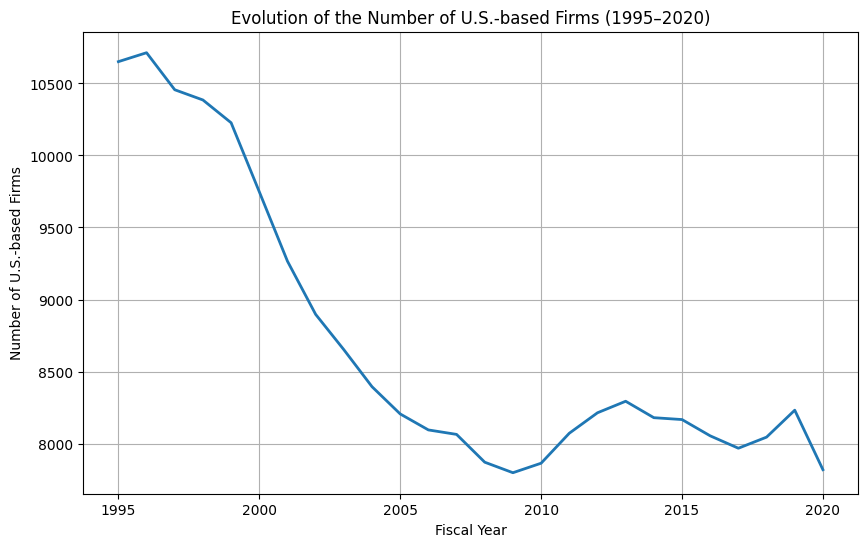

In [92]:
#Plot the evolution of the number of US-based firms over time
plt.figure(figsize=(10,6))
plt.plot(firms_per_year["fyear"], firms_per_year["n_firms"], linewidth=2)
plt.xlabel("Fiscal Year")
plt.ylabel("Number of U.S.-based Firms")
plt.title("Evolution of the Number of U.S.-based Firms (1995–2020)")
plt.grid(True)
plt.show()

**Interpretation:**

We begin by checking the Compustat dataset for duplicate firm–year observations. Using the firm identifier (gvkey) and the fiscal year (fyear), we identify 61,634 duplicate observations out of an initial 329,589 observations. Since each firm should appear only once per fiscal year, these duplicates do not provide additional information and are therefore removed. After eliminating duplicate firm–year observations, the sample size decreases to 298,772 observations, ensuring a clean panel structure.
Next, we identify firms that are not headquartered in the United States using the headquarters location variable (loc). We find 72,439 non-U.S. firm–year observations, which are excluded from the sample. Restricting the data to U.S.-based firms leaves 226,333 observations. This restriction is important because firms headquartered outside the U.S. operate under different institutional, regulatory, and accounting environments, which could introduce heterogeneity unrelated to firms’ capital structure and financial policies.
After these cleaning steps, we analyze the evolution of the number of U.S.-based firms over the fiscal years 1995 to 2020. The time-series plot shows that the number of U.S.-based firms is highest in the mid-to-late 1990s, peaking at slightly above 10,700 firms. This period coincides with an intense wave of IPO activity and strong equity market conditions, particularly during the dot-com boom.


#### 1.2 Winsorize each ratio at 1st and 99th percentile in each fiscal year. Create a table with summary statistics that contains: the mean, the median, the minimum, the maximum, the standard deviation and the number of non-missing observations for each of the financial ratios. Hint: to winsorize means to set values below (or above) a certain quantile to the value of that quantile in the data; each ratio will typically have a different number of non-missing observations.

In [93]:
#Creation of lag 1st and 99th percentiles for at and prcc_f
df_us = df_us.sort_values(["gvkey", "fyear"])

df_us["lat"] = df_us.groupby("gvkey")["at"].shift(1)
df_us["lprice"] = df_us.groupby("gvkey")["prcc_f"].shift(1)

In [94]:
#Build all ratios
df_us["book_leverage_1"] = (df_us["dlc"] + df_us["dltt"]) / df_us["at"]
df_us["book_leverage_2"] = df_us["lt"] / df_us["at"]

df_us["mkt_equity"] = df_us["csho"] * df_us["prcc_f"]
df_us["market_leverage"] = (df_us["dlc"] + df_us["dltt"]) / (
    df_us["dlc"] + df_us["dltt"] + df_us["pstk"] + df_us["mkt_equity"]
)

df_us["market_to_book"] = (
    df_us["mkt_equity"] + df_us["dltt"] + df_us["dlc"] + df_us["pstkl"] - df_us["txditc"]
) / df_us["at"]

df_us["asset_growth"] = df_us["at"] / df_us["lat"] - 1
df_us["asset_tangibility"] = df_us["ppent"] / df_us["at"]
df_us["roe"] = df_us["ni"] / df_us["ceq"]
df_us["profit_margin"] = df_us["ni"] / df_us["sale"]
df_us["capex_ratio"] = df_us["capx"] / df_us["at"]
df_us["dividend_yield"] = (df_us["dv"] / df_us["csho"]) / df_us["lprice"]
df_us["dividend_payout"] = df_us["dv"] / df_us["ni"]
df_us["total_payout"] = (df_us["dv"] + df_us["prstkc"]) / df_us["ni"]
df_us["interest_coverage"] = df_us["ebit"] / df_us["xint"]
df_us["cash_holdings"] = df_us["che"] / df_us["at"]
df_us["profitability"] = df_us["oibdp"] / df_us["at"]

In [95]:
#List of all the ratios
ratios = [
    "book_leverage_1",
    "book_leverage_2",
    "mkt_equity",
    "market_leverage",
    "market_to_book",
    "asset_growth",
    "asset_tangibility",
    "roe",
    "profit_margin",
    "capex_ratio",
    "dividend_yield",
    "dividend_payout",
    "total_payout",
    "interest_coverage",
    "cash_holdings",
    "profitability"
]

In [96]:
# Winsorisation
def winsorize_by_year(df, var, year_col="fyear", p_low=0.01, p_high=0.99):
    return df.groupby(year_col)[var].transform(
        lambda x: x.clip(lower=x.quantile(p_low), upper=x.quantile(p_high))
    )

In [97]:
# Winsorize all ratios
for var in ratios:
    df_us[var] = df_us[var].replace([np.inf, -np.inf], np.nan) # Replace inf with NaN ASK THE TEACHER
    df_us[var + "_w"] = winsorize_by_year(df_us, var)

In [98]:
#Descriptive Statistic
summary_stats = []

for var in ratios:
    x = df_us[var + "_w"]
    summary_stats.append({
        "Variable": var,
        "Mean": x.mean(),
        "Median": x.median(),
        "Min": x.min(),
        "Max": x.max(),
        "Std": x.std(),
        "N": x.notna().sum() # Count of non-missing values
    })

summary_table = pd.DataFrame(summary_stats)
summary_table

summary_table.round(4)

,Variable,Mean,Median,Min,Max,Std,N
0,book_leverage_1,0.3900,0.1942,0.0000,17.1534,1.0582,181594
1,book_leverage_2,1.0053,0.6017,0.0218,50.2667,2.9557,183264
2,mkt_equity,1737.7956,139.7282,0.0901,89789.0763,6265.7650,169253
3,market_leverage,0.2243,0.1326,0.0000,0.9840,0.2511,133938
4,market_to_book,6.3744,1.3148,0.1252,978.1067,38.1025,128429
5,asset_growth,0.3621,0.0535,-0.9454,33.4665,1.7298,163723
6,asset_tangibility,0.2227,0.1172,0.0000,0.9487,0.2515,180139
7,roe,0.0162,0.0740,-15.8232,17.7177,1.9546,155459
8,profit_margin,-2.7306,0.0160,-300.5355,1.2082,17.1238,146022
9,capex_ratio,0.0532,0.0304,0.0000,0.4866,0.0715,153336


#### 1.3 Split the firms into 4 groups (quartiles) each year depending on the market value of equity. Create a table with summary statistics of ALL variables in Table 1 for the firms in the smallest and largest quartiles that contains the mean, the median and the standard deviation for each of the two subsamples. Comment on the main differences between the two samples and provide a reason why this may be the case.


In [99]:
#Create yearly quartiles
df_us["size_quartile"] = (
    df_us.groupby("fyear")["mkt_equity"]
    .transform(lambda x: pd.qcut(x, 4, labels=[1, 2, 3, 4])) #à vérifier avec le prof SI ON AJOUTE CE QUE J'AI MIS DANS L'AUTRE CODE
)

In [100]:
#ÉTAPE 3 — Définir les deux sous-échantillons
small_firms = df_us[df_us["size_quartile"] == 1]
large_firms = df_us[df_us["size_quartile"] == 4]

In [101]:
#ÉTAPE 4 — Liste des ratios winsorisés (Table 1)
ratios_w = [
    "book_leverage_1_w",
    "book_leverage_2_w",
    "market_leverage_w",
    "market_to_book_w",
    "asset_growth_w",
    "asset_tangibility_w",
    "roe_w",
    "profit_margin_w",
    "capex_ratio_w",
    "dividend_yield_w",
    "dividend_payout_w",
    "total_payout_w",
    "interest_coverage_w",
    "cash_holdings_w",
    "profitability_w"
]

In [102]:
#ÉTAPE 5 — Fonction pour créer la table demandée
def summary_by_group(df, variables):
    rows = []
    for var in variables:
        rows.append({
            "Variable": var.replace("_w", ""),
            "Mean": df[var].mean(),
            "Median": df[var].median(),
            "Std": df[var].std()
        })
    return pd.DataFrame(rows)

In [103]:
#ÉTAPE 6 — Tables finales Q1 vs Q4
table_small = summary_by_group(small_firms, ratios_w)
table_large = summary_by_group(large_firms, ratios_w)

table_small["Group"] = "Small firms (Q1)"
table_large["Group"] = "Large firms (Q4)"

final_table = pd.concat([table_small, table_large])
final_table

final_table.round(4)

,Variable,Mean,Median,Std,Group
0,book_leverage_1,0.8527,0.2427,2.0885,Small firms (Q1)
1,book_leverage_2,2.3693,0.6491,5.9625,Small firms (Q1)
2,market_leverage,0.2885,0.1750,0.3044,Small firms (Q1)
3,market_to_book,12.0768,1.1746,56.1389,Small firms (Q1)
4,asset_growth,0.2440,-0.0563,1.7219,Small firms (Q1)
5,asset_tangibility,0.2165,0.1121,0.2508,Small firms (Q1)
6,roe,0.0521,0.0296,2.8904,Small firms (Q1)
7,profit_margin,-5.7198,-0.1204,24.6790,Small firms (Q1)
8,capex_ratio,0.0420,0.0151,0.0750,Small firms (Q1)
9,dividend_yield,0.0044,0.0000,0.0198,Small firms (Q1)


**Interpretation:**

Firms are sorted each fiscal year into four quartiles based on their market value of equity. The market value of equity is computed as the product of shares outstanding and stock price and is winsorized at the 1st and 99th percentiles within each year to mitigate the influence of extreme observations. Quartile 1 (Q1) corresponds to the smallest firms, while Quartile 4 (Q4) corresponds to the largest firms. **We did not take in account Q2 and Q3 since it represent small-medium and medium to large firms.** Summary statistics are reported for all financial ratios in Table 1 for firms in the smallest and largest size quartiles.

The results reveal substantial differences in financial characteristics between small and large firms. Small firms exhibit significantly higher leverage ratios, both in book (e.g. Q1 mean is 0.8527 and Q4 mean is 0.2669) and market terms (e.g. Q1 mean is 0.2885 and Q4 mean is 0.2064), and display considerably higher volatility across most variables (e.g. interest_coverage Q1(207,58) vs Q4(156.29)). Their market-to-book ratios are substantially larger and more dispersed, reflecting higher growth opportunities but also greater uncertainty. Small firms also show lower profitability, with negative average profit margins and return on equity, as well as weaker interest coverage ratios, indicating greater financial distress and higher operating risk.

In contrast, large firms are more profitable and financially stable. They exhibit lower leverage, higher and more stable profitability, and stronger interest coverage ratios, suggesting a greater capacity to service debt. Large firms also invest more in capital expenditures relative to assets and distribute a larger share of earnings to shareholders through dividends and total payouts. Additionally, large firms hold lower cash ratios on average, consistent with easier access to external financing and lower precautionary savings needs.
Overall, these differences are consistent with standard corporate finance theories. Smaller firms face greater information asymmetry, limited access to capital markets, and higher business risk, which translate into higher leverage volatility and weaker profitability. Larger firms benefit from economies of scale, more diversified operations, and better access to financing, leading to more stable financial structures and higher payout capacity.


**À réduire**

#### 1.4 Split the firms into financial and non-financial ones. To do so, use the industry indicator sic: you can identify financial firms as those whose first two digits of the SIC code are between 60 and 67 (inclusive). How many financial and non-financial firms are there, on average, in the sample every fiscal year? Create also an indicator for utility/regulated firms, whose first two digits of the SIC code are between 40 and 49 (inclusive).

In [104]:
#Clean sic and extract first 2 digits
df_us["sic2"] = (df_us["sic"].astype(str).str.zfill(4).str[:2].astype(int))

In [105]:
#Step 1 - Define industry groups
# Financial firms: SIC 60–67
df_us["is_financial"] = df_us["sic2"].between(60, 67)

# Utility / regulated firms: SIC 40–49
df_us["is_utility"] = df_us["sic2"].between(40, 49)

# Non-financial firms
df_us["is_non_financial"] = ~df_us["is_financial"]

In [106]:
#Step 2 - Number of firms per industry group and fiscal year
yearly_financial = (df_us[df_us["is_financial"]].groupby("fyear")["gvkey"].nunique().reset_index(name="n_financial"))

yearly_non_financial = (df_us[~df_us["is_financial"]].groupby("fyear")["gvkey"].nunique().reset_index(name="n_non_financial"))

yearly_utility = (df_us[df_us["is_utility"]].groupby("fyear")["gvkey"].nunique().reset_index(name="n_utility"))

yearly = yearly_financial.merge(yearly_non_financial, on="fyear").merge(yearly_utility, on="fyear")

yearly.head()

,fyear,n_financial,n_non_financial,n_utility
0,1995,2436,8215,975
1,1996,2384,8329,965
2,1997,2277,8179,936
3,1998,2295,8090,922
4,1999,2358,7869,896


In [107]:
#Step 3 — Mean over the period
averages = yearly[["n_financial", "n_non_financial", "n_utility"]].mean()
averages

n_financial        2909.307692
n_non_financial    5795.807692
n_utility           677.769231
dtype: float64

#### 1.5. Using book leverage (1) and (2) as well as market leverage, create a table that contains the mean, the median, the standard deviation and the number of observations for each:
##### (a) the sample of financial firms,
##### (b) the sample of utility firms,
##### (c) the sample of non-financial and non-utility firms,
##### (d) the sample of non-financial and non-utility/regulated firms with non-missing value of total assets throughout the whole sample period.

In [108]:
#Step 1 - Define the 4 subsamples
# (a) Financial firms
sample_a = df_us[df_us["is_financial"]]

# (b) Utility firms
sample_b = df_us[df_us["is_utility"]]

# (c) Non-financial & non-utility firms
sample_c = df_us[~df_us["is_financial"] & ~df_us["is_utility"]]
#Step 2 - Define subsample (d) : firms with at non-missing over the ENTIRE period
#Identify firms with at non-missing over their entire observation period
valid_firms = (df_us.groupby("gvkey")["at"].apply(lambda x: x.notna().all()))

valid_gvkeys = valid_firms[valid_firms].index

# (d) Non-financial & non-utility firms with at non-missing over the ENTIRE period
sample_d = df_us[(~df_us["is_financial"]) & (~df_us["is_utility"]) & (df_us["gvkey"].isin(valid_gvkeys))]

In [109]:
#Step 3 — Function to calculate leverage stats
leverage_vars = [
    "book_leverage_1_w",
    "book_leverage_2_w",
    "market_leverage_w"
]

def leverage_summary(df, label):
    rows = []
    for var in leverage_vars:
        rows.append({
            "Sample": label,
            "Leverage measure": var.replace("_w", ""),
            "Mean": df[var].mean(),
            "Median": df[var].median(),
            "Std": df[var].std(),
            "N": df[var].notna().sum()
        })
    return pd.DataFrame(rows)

In [110]:
table_a = leverage_summary(sample_a, "Financial firms")
table_b = leverage_summary(sample_b, "Utility firms")
table_c = leverage_summary(sample_c, "Non-financial & non-utility")
table_d = leverage_summary(sample_d, "Non-financial & non-utility (balanced at)")

final_table = pd.concat([table_a, table_b, table_c, table_d])
final_table.round(4)

,Sample,Leverage measure,Mean,Median,Std,N
0,Financial firms,book_leverage_1,0.2673,0.1301,0.5860,38463
1,Financial firms,book_leverage_2,0.8570,0.8710,1.5249,39927
2,Financial firms,market_leverage,0.3030,0.2331,0.2967,10262
0,Utility firms,book_leverage_1,0.4393,0.3469,0.7229,16968
1,Utility firms,book_leverage_2,0.8600,0.6744,1.8304,16977
2,Utility firms,market_leverage,0.3599,0.3535,0.2453,11718
0,Non-financial & non-utility,book_leverage_1,0.4208,0.1879,1.1962,126163
1,Non-financial & non-utility,book_leverage_2,1.0717,0.5145,3.3870,126360
2,Non-financial & non-utility,market_leverage,0.2029,0.1086,0.2411,111958
0,Non-financial & non-utility (balanced at),book_leverage_1,0.3895,0.1857,1.0967,111511


#### 1.6 Comment on the following (provide a reason why we observe what we observe):

##### (a) The differences in financial leverage between 1. financial, 2. utility/regulated and 3.non-financial, non-utility/regulated firms.


Financial firms: Financial firms display relatively low book leverage 1 (mean = 0.2673) and market leverage (mean = 0.3030) compared to other groups. However, their book leverage 2 (mean = 0.8570) reflects a higher reliance on liabilities. This is due to their nature, which holds significant amounts of debt due to their lending, investment, and funding operations. In fact, the higher leverage ratio, the more it aligns with their business model, which often uses borrowed funds to generate returns.


Utility firms: Utility firms has a high book_leverage_2 (mean = 0.86) because they require enormous long-term debt for infrastructure investments, such as natural ressource (e.g. water, gaz & electricity), telecommunications systems, stem, transportation, etc.  


Non-financial & non utility: On the other hand, we can observe that non-financial and non-utility firms have lower market leverage (mean = 0.2029). This means  that these firms rely more on equity financing due to a stronger market valuations. However, the fact that their  book leverage 2 is substantially higher (mean = 1.0717) suggest that they rely  on liabilities  to their asset bases.  

This difference reflects how market valuations capture growth potential. In fact, while the market leverage looks at the firm's value in the stock market, the  book leverage focuses on the accounting value of their assets, which might not include all growth or intangible assets. Consequently, the difference in leverage formthese firms comes from   how companies in various sectors are financed, unlike utility firms, which are mainly tied to large sector-specific debt for infrastructure investments.



##### (b) The differences in financial leverage between non-financial firms and non-financial with non-missing value of total assets throughout the whole sample period. 


Non-financial with non-missing value of total asset data present lower financial leverage across all measures compared to the  non-financial firms. Firstly, for book leverage 1, the mean drops from 0.4208 to 0.3895, and for book leverage 2, it decreases from 1.0717 to 0.9815. This difference can be explained by the fact that firms with consistent reporting data might be more stable financially, with better governance practices that allow them to manage debts more effectively. This can lead to less reliance on liabilities and clearer financial strategies. 


In contrast, non-financial firms with missing total asset observations likely introduce higher variability and financial risk, as reflected in their elevated book leverage values. Therefore, it is important to have consistent data for interpreting financial stability and leverage measures.



#### Based on the results, is it justified that financial and utility/regulated firms are often excluded from empirical analysis? Why (not)?


Yes, it is justified to exclude financial and utility/regulated firms from empirical analysis. Firstly, for a financial firms, debt is a primary part of their operations, and their leverage ratios do not align with other sectors. In fact, including them can twist results, because their high leverage does not necessarily reflect financial distress or inefficiency. 

Similarly, utility firms have a regulated environment and dependence on debt financing for infrastructure investments. Their high-leverage metrics depend on different types of sectors, making them less relevant for research purposes in empirical analysis.

To conclude, by avoiding biases introduced by these specialized industries, it will help us analyze more general patterns within non-financial and non-utility firms.

## **2. Exploratory Data Analysis**
### We are now going to focus on the winsorized sample of non-financial and non-utility firms. Focus on six financial ratios: **book leverage (1), EBIT interest coverage, cash, profitability, total payout ratio, market-to-book**

#### 2.1 Report the following
##### a. A histogram-scatter matrix (Hint: check pandas.plotting.scatter matrix),

In [111]:
#Creation of working sample
#Sample EDA : non-financial & non-utility, données winsorisées
df_eda = df_us[(~df_us["is_financial"]) & (~df_us["is_utility"])].copy()

eda_vars = {
    "book_leverage_1_w": "Book leverage",
    "interest_coverage_w": "Interest coverage",
    "cash_holdings_w": "Cash holdings",
    "profitability_w": "Profitability",
    "total_payout_w": "Total payout ratio",
    "market_to_book_w": "Market-to-book"
}

cols = list(eda_vars.keys())

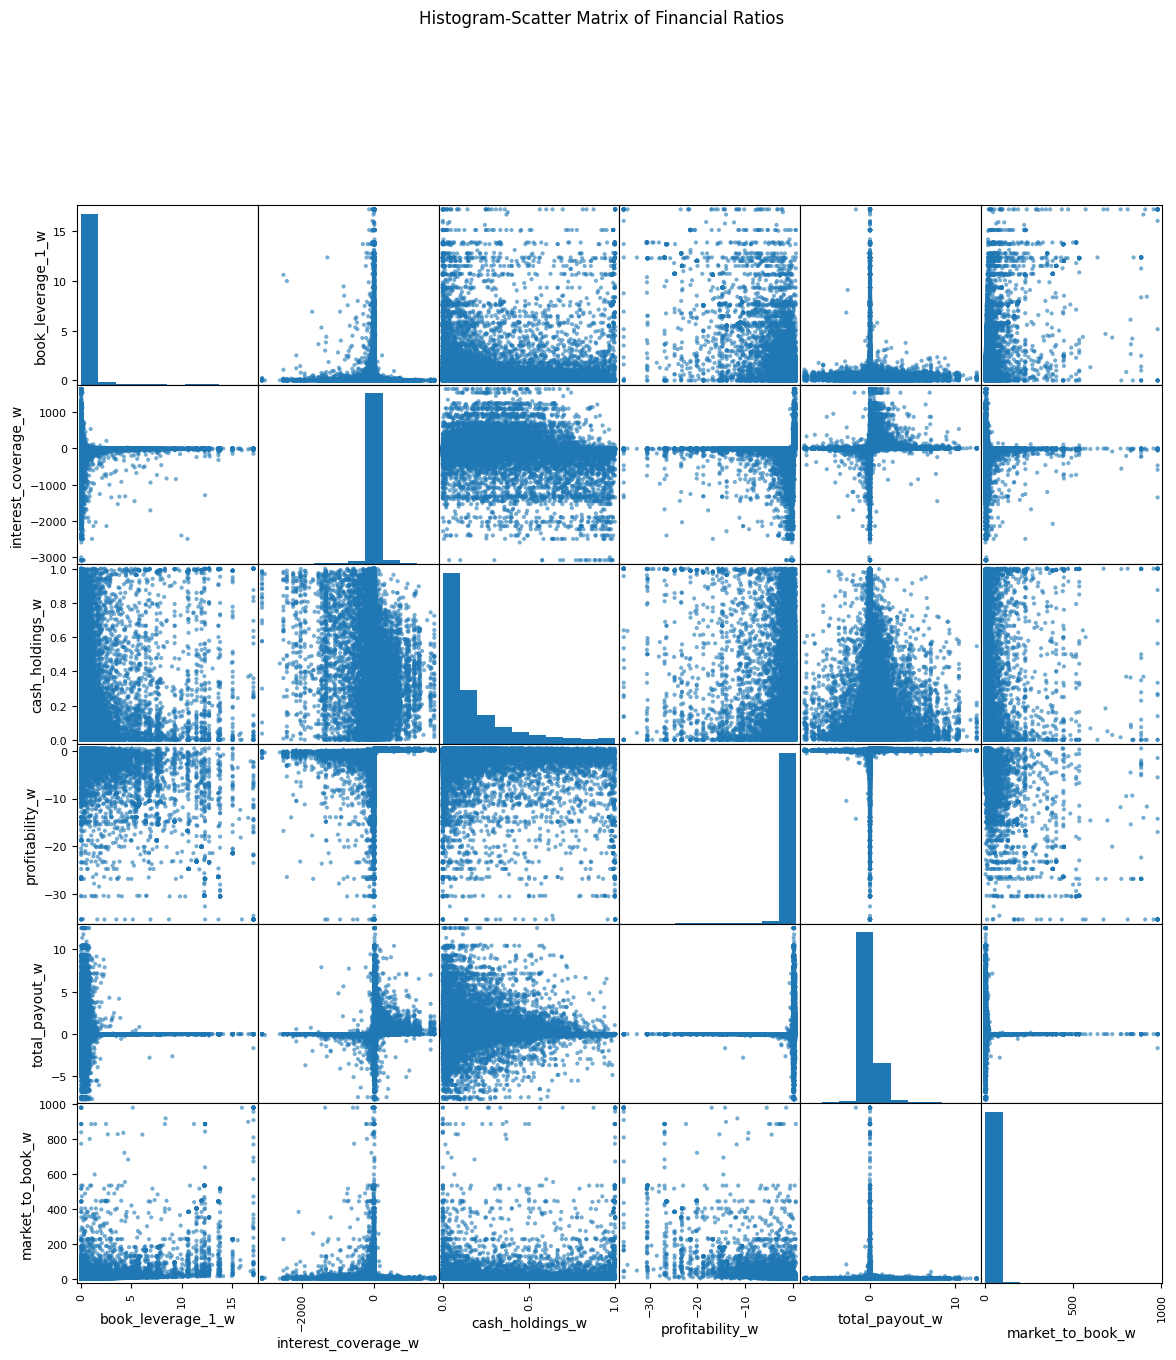

In [112]:
#a. Histogram–scatter matrix
X = (df_eda[cols].replace([np.inf, -np.inf], np.nan).dropna()) #enlevé les inf et -inf pour que le graphique fonctionne

scatter_matrix(X,figsize=(14, 14),diagonal="hist",alpha=0.6)

plt.suptitle("Histogram-Scatter Matrix of Financial Ratios", y=1.02)
plt.show()

**Interpretation:**

**Distribution of variables**:

The histogram–scatter matrix reveals that most financial ratios exhibit strong asymmetry and fat tails. In particular, book leverage, cash holdings, market-to-book, and total payout ratios are right-skewed, with a large mass of observations at low values and a small number of extreme positive observations. In contrast, profitability is left-skewed, reflecting the presence of firms with large negative profits, while the majority of firms cluster around small positive or near-zero values.

The interest coverage ratio displays extreme dispersion and asymmetry, with both very large positive and negative values, which is mainly driven by firms with low or negative earnings.

**Scarlet plot**: 

The scatter plots do not reveal strong linear relationships between most pairs of variables. However, some weak patterns can be observed. Firms with higher cash holdings tend to exhibit lower leverage, while more profitable firms appear to rely less on external financing.

Overall, the relationships between variables are highly dispersed and non-linear, suggesting substantial heterogeneity across firms.

##### b. for each ratio, a time-series graph that contains the average and the aggregate value of the corresponding ratio over the sample period. Hint: to aggregate, compute the sum of each of the components of the financial ratio in a given fiscal year and then compute the ratio itself.

In [113]:
#b. temporal series: Average vs Aggregate
def plot_avg_vs_agg(df, avg_var, num_var, den_var, title, ylabel):
    yearly = df.groupby("fyear").agg(
        avg=(avg_var, "mean"),
        num=(num_var, "sum"),
        den=(den_var, "sum")
    )
    yearly["agg"] = yearly["num"] / yearly["den"]

    plt.figure(figsize=(10,6))
    plt.plot(yearly.index, yearly["avg"], label="Average", linewidth=2)
    plt.plot(yearly.index, yearly["agg"], label="Aggregate", linewidth=2)
    plt.title(title)
    plt.xlabel("Fiscal Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

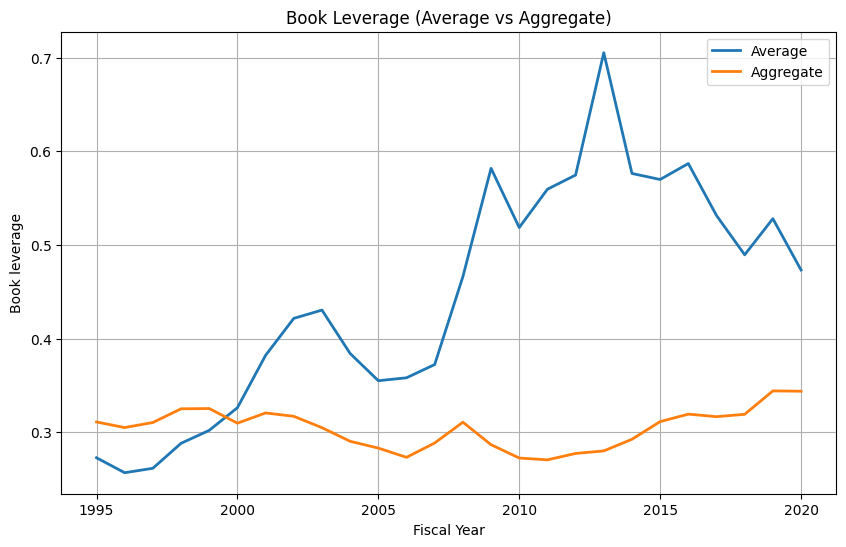

In [114]:
#Book leverage (1)
df_eda["total_debt"] = df_eda["dltt"]. fillna(0) + df_eda["dlc"].fillna(0)
plot_avg_vs_agg(df_eda, "book_leverage_1_w", "total_debt", "at", "Book Leverage (Average vs Aggregate)", "Book leverage") #Voir la formule

**Interpretation:**

We observe that the average book leverage is higher than the aggregate book leverage for most of the period from 1999 to 2020, reaching values as high as 0.7. This pattern is consistent with the increased reliance on debt financing during the 2008 financial crisis. In particular, small and medium-sized firms appear to have relied more heavily on debt in order to continue operating during this period, which explains the sharp increase in the average leverage measure.

After 2013, the average book leverage declines, suggesting a gradual deleveraging of these firms. In contrast, the aggregate book leverage remains relatively stable over the entire sample period, fluctuating around 0.35. This difference arises because the aggregate measure is dominated by large firms, which were able to reduce their leverage more quickly and maintain more stable capital structures compared to smaller firms.

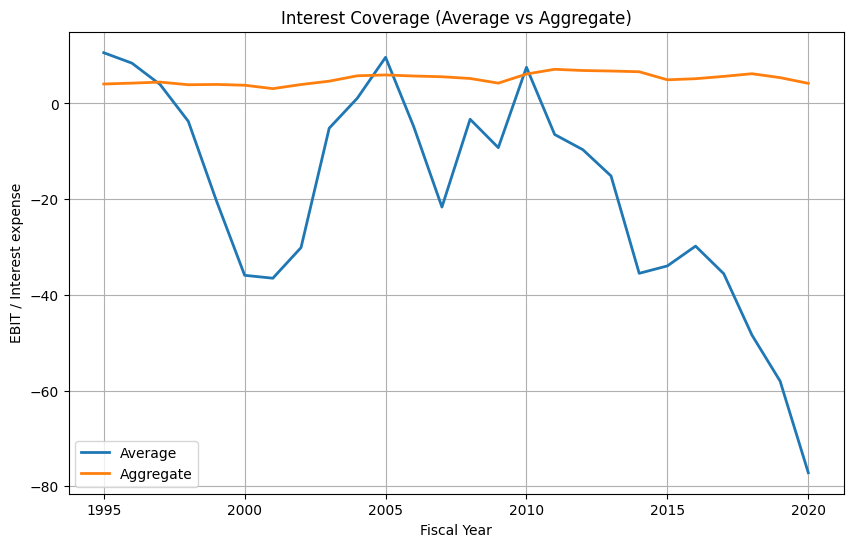

In [115]:
#Interest coverage
plot_avg_vs_agg(df_eda, "interest_coverage_w", "ebit", "xint", "Interest Coverage (Average vs Aggregate)", "EBIT / Interest expense")

**Interpretation:**

The average interest coverage ratio exhibits substantial volatility and becomes strongly negative during several periods, notably in the early 2000s, during the 2008–2009 financial crisis, and after 2015. In contrast, the aggregate interest coverage ratio remains positive and relatively stable throughout the sample period.

This discrepancy reflects a strong size effect. The average measure gives equal weight to all firms and is therefore heavily influenced by small firms and firms with negative EBIT. The aggregate measure, on the other hand, is dominated by large firms, whose higher and more stable earnings allow them to cover interest expenses more easily. As a result, even when a large number of firms experience financial distress, the aggregate interest coverage remains positive.

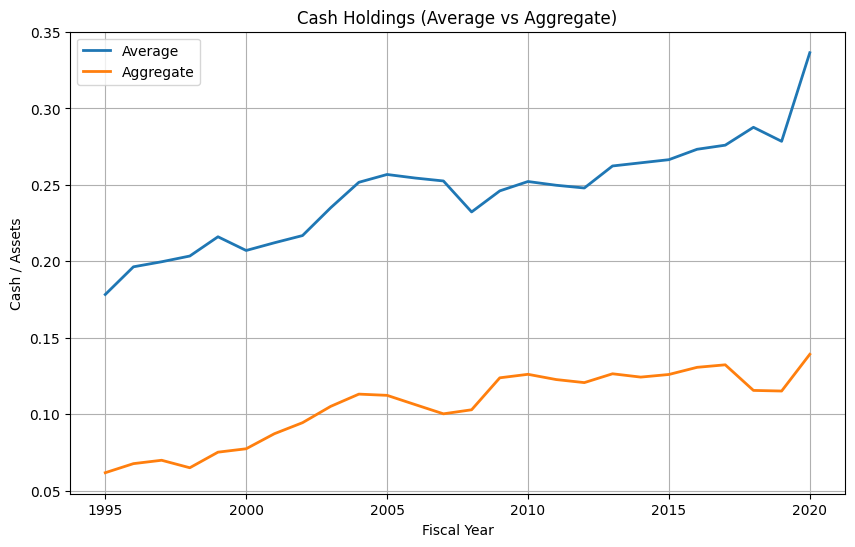

In [116]:
#Cash holdings
plot_avg_vs_agg(df_eda, "cash_holdings_w", "che", "at", "Cash Holdings (Average vs Aggregate)", "Cash / Assets")

**Interpretation:**

The average cash holdings ratio is consistently higher than the aggregate ratio over the entire sample period. Both measures exhibit an upward trend, particularly after the early 2000s, indicating a general increase in firms’ liquidity over time. However, the rise is substantially stronger for the average measure.

This pattern reflects firm heterogeneity. The average ratio gives equal weight to all firms and is therefore driven by small and medium-sized firms, which tend to hold more cash for precautionary reasons due to greater financing constraints and higher uncertainty. In contrast, the aggregate ratio is dominated by large firms, which have better access to external financing and can operate with lower relative cash holdings.

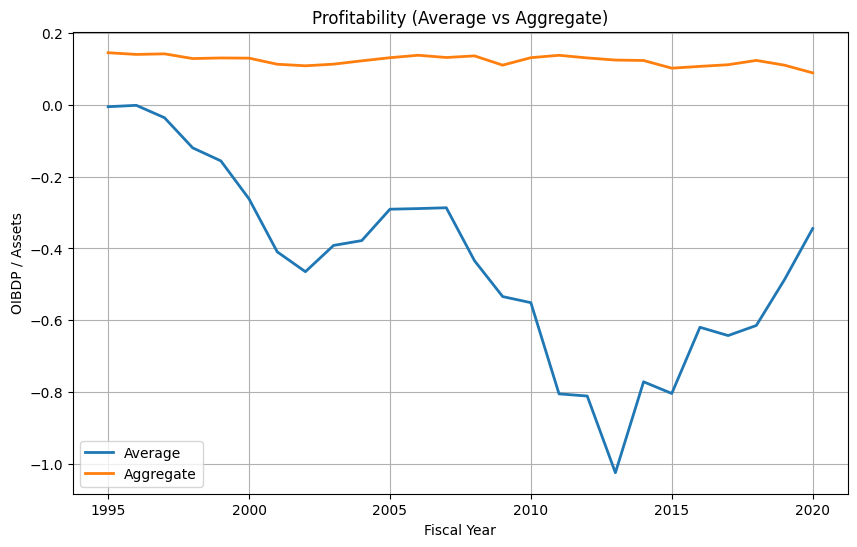

In [117]:
#Profitability
plot_avg_vs_agg(df_eda, "profitability_w", "oibdp", "at", "Profitability (Average vs Aggregate)", "OIBDP / Assets")

**Interpretation:**

We observe that the average profitability is consistently below the aggregate profitability over the entire sample period. This indicates that smaller and medium-sized firms experienced significantly lower profitability, and in many years negative profitability, compared to large firms.

The aggregate profitability remains positive and relatively stable around 0.1 from 1995 to 2020, suggesting that large firms were more resilient to major economic downturns such as the early 2000s recession, the 2008 financial crisis, and the COVID-19 shock.

In contrast, the average profitability declines sharply during crisis periods, reflecting the greater vulnerability of smaller firms to economic shocks, higher operating leverage, and more limited access to external financing. As a result, firm heterogeneity plays a crucial role in explaining the divergence between average and aggregate profitability.

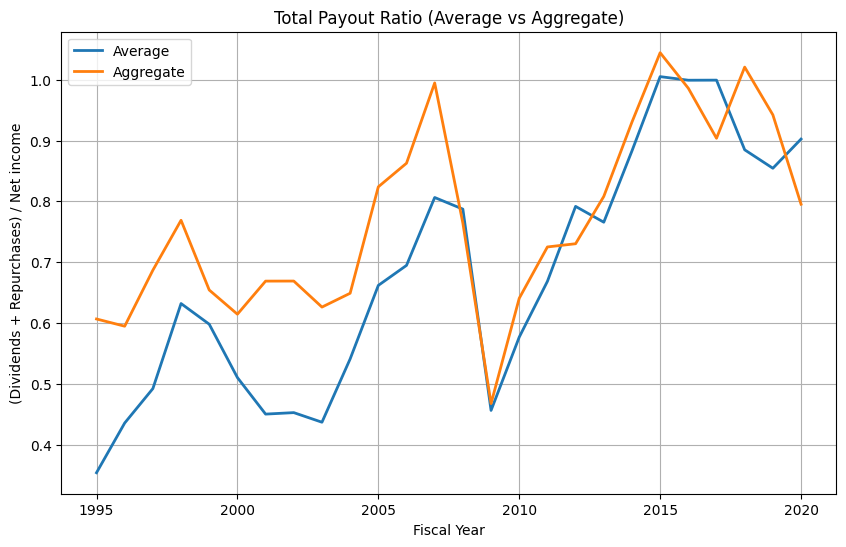

In [118]:
#Total payout ratio
df_payout = df_eda[df_eda["ni"] > 0]. copy()
df_payout["total_payout_num"] = df_payout["dv"]. fillna(0) + df_payout["prstkc"].fillna(0)
plot_avg_vs_agg(df_payout, "total_payout_w", "total_payout_num", "ni",   "Total Payout Ratio (Average vs Aggregate)", "(Dividends + Repurchases) / Net income")

**Interpretation:**

We observe that the average and aggregate total payout ratios follow a similar overall pattern over time and decline sharply around major economic crises. This behavior is particularly evident during the early 2000s downturn, the 2008 financial crisis, and the COVID-19 period.

During crisis periods, firms tend to reduce dividends and share repurchases in order to preserve liquidity and strengthen their balance sheets. Maintaining cash buffers and servicing debt becomes a priority, which mechanically lowers the total payout ratio.

Outside of crisis episodes, the total payout ratio increases gradually and remains relatively stable, reflecting more favorable economic conditions and stronger cash-flow generation. The similarity between the average and aggregate series suggests that payout policies respond systematically to macroeconomic conditions across firms of different sizes, although large firms tend to smooth payouts more effectively over time.

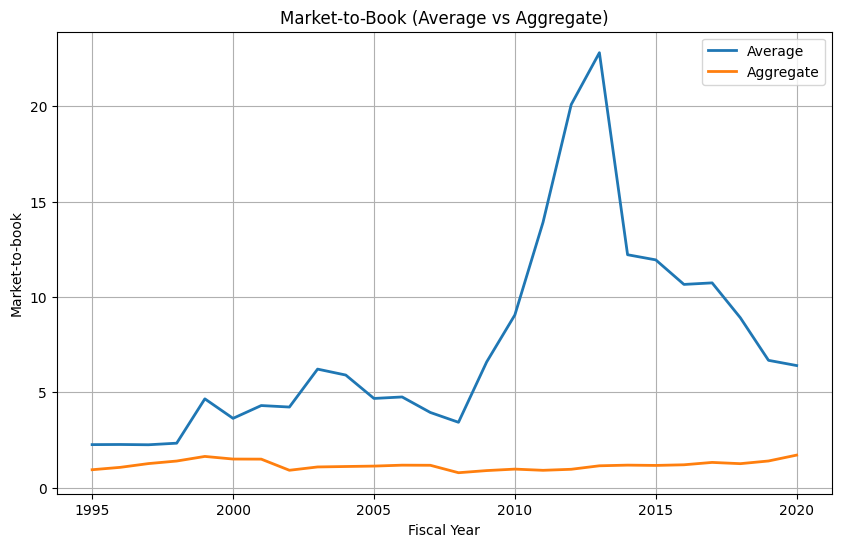

In [119]:
#Market-to-book
plot_avg_vs_agg(df_eda, "market_to_book_w", "mkt_equity", "at", "Market-to-Book (Average vs Aggregate)", "Market-to-book")

**Interpretation:**

We observe that the aggregate market-to-book ratio remains close to one over the sample period. This reflects the fact that aggregate measures are dominated by large firms, whose market values tend to track their accounting values more closely. Large firms are typically more mature, less growth-oriented, and subject to greater analyst coverage, which limits valuation dispersion at the aggregate level.

In contrast, the average market-to-book ratio exhibits substantial volatility and a sharp increase in the early 2010s, reaching values above 20, followed by a pronounced decline. This behavior indicates the presence of firms with very high growth opportunities or extremely low book equity, which mechanically inflates the market-to-book ratio when firms are equally weighted.

The divergence between the average and aggregate series highlights the strong heterogeneity across firms. Small and growth firms, which receive the same weight in the average, tend to drive the large spikes in market-to-book ratios. The subsequent decline after the peak likely reflects a combination of valuation corrections and a normalization of market expectations following periods of excessive optimism, rather than regulation alone.

#### 2. Create a correlation matrix of the six variables. Then, transform each of the six variables by removing the firm-specific mean and create another correlation matrix for these variables. **1** Which differences do you observe between the two matrices?

1 This means you should have as many different means as there are firms and then remove this mean from each
observation of interest:  ̃xit = xit − ̄xi, where i is firm and t is fiscal year.

In [120]:
#Step - 01 — List of the 6 variables
cols = [
    "book_leverage_1_w",
    "interest_coverage_w",
    "cash_holdings_w",
    "profitability_w",
    "total_payout_w",
    "market_to_book_w"
]

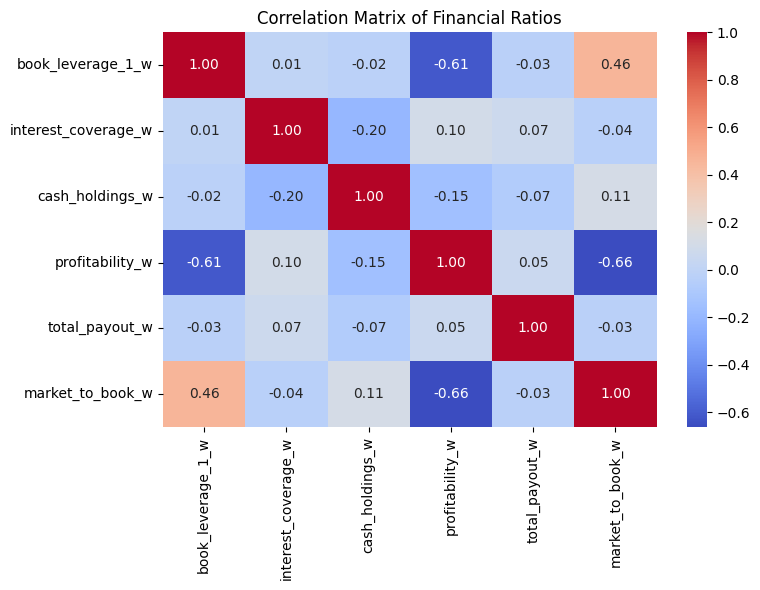

In [121]:
#Step 1 - Correlation matrix raw
X_raw = (df_eda[cols].replace([np.inf, -np.inf], np.nan))# Remove rows with any missing values

#Raw correlation 
corr_raw = X_raw.corr()
corr_raw.round(4)

#Plot heatmap of raw correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_raw, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Financial Ratios")
plt.tight_layout()
plt.show()

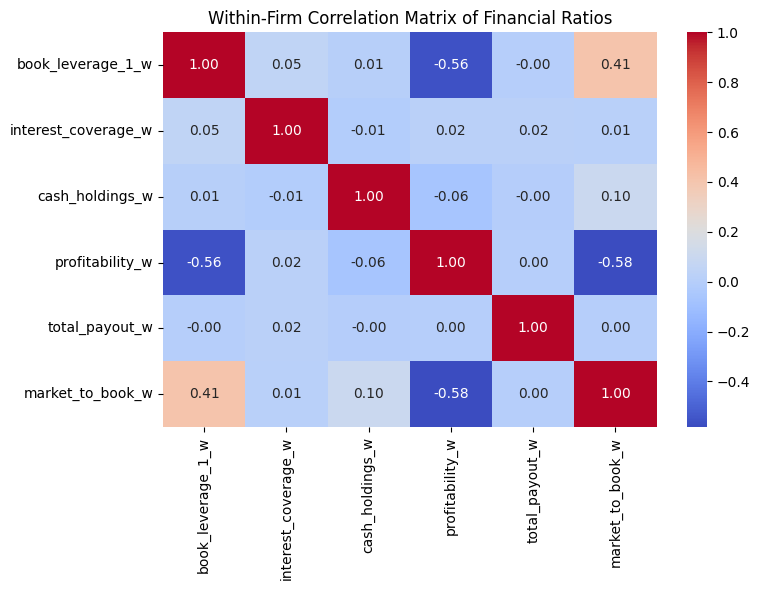

In [122]:
#Step 2 - Correlation matrix within
X_raw = df_eda[["gvkey"] + cols]. replace([np.inf, -np.inf], np.nan).dropna()

X_within = X_raw.copy()
for var in cols:
    X_within[var] = X_raw[var] - X_raw.groupby("gvkey")[var].transform("mean")

corr_within = X_within[cols].corr()
corr_within.round(4)

#plot heatmap of within-firm correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_within, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Within-Firm Correlation Matrix of Financial Ratios")
plt.tight_layout()
plt.show()

Interprétation : 

#### 2.3. Let us consider the following model: $$ y_it = α + βx_it + ε_it $$, where y is book leverage and x is profitability.

##### a. Estimate the model using OLS. Report the results. Use appropriate standard errors. Motivate your choice.

In [123]:
#Pourquoi des SE “clustered” ? Tes données sont panel (firmes observées sur plusieurs années) → les erreurs sont corrélées dans une firme au fil du temps (autocorr, hétéroscédasticité).
# Donc, choix standard : cluster par firme (gvkey).
# À enlever pour le propre et le mettre dans le pdf le choix des SE cluster par firme et expliquer plus en détail.

yvar = "book_leverage_1_w"
xvar = "profitability_w"

df_reg = df_eda[[ "gvkey", "fyear", yvar, xvar ]].replace([np.inf, -np.inf], np.nan).dropna()

X = sm.add_constant(df_reg[xvar])
y = df_reg[yvar]

ols = sm.OLS(y, X).fit(cov_type="cluster",cov_kwds={"groups": df_reg["gvkey"]})

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      book_leverage_1_w   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     965.4
Date:                Wed, 28 Jan 2026   Prob (F-statistic):          5.56e-205
Time:                        13:03:21   Log-Likelihood:            -1.6984e+05
No. Observations:              124687   AIC:                         3.397e+05
Df Residuals:                  124685   BIC:                         3.397e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2944      0.004     

**Interpretation:**

Motivation: 


Result:

signe de 𝛽

-β (souvent négatif : plus profitable → moins de dette, pecking order / internal funds)

-significance

-justifier cluster firm (panel dependence)

##### b. Estimate the following model using OLS  ̃y_it =  ̄α +  ̄β ̃x_it +  ̄ε_it, where  ̃xit correspond to transforming the data in the same way as in question 2 where you transformed it before reporting correlations. What do you notice about  ̄β as compared to the estimates that you found in parts a?

In [124]:
df_w = df_reg.copy()

df_w["y_tilde"] = df_w[yvar] - df_w.groupby("gvkey")[yvar].transform("mean")
df_w["x_tilde"] = df_w[xvar] - df_w.groupby("gvkey")[xvar].transform("mean")

Xw = sm.add_constant(df_w["x_tilde"])
yw = df_w["y_tilde"]

ols_within = sm.OLS(yw, Xw).fit(cov_type="cluster", cov_kwds={"groups": df_w["gvkey"]})

print(ols_within.summary())

                            OLS Regression Results                            
Dep. Variable:                y_tilde   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     707.5
Date:                Wed, 28 Jan 2026   Prob (F-statistic):          4.30e-152
Time:                        13:03:21   Log-Likelihood:            -1.3621e+05
No. Observations:              124687   AIC:                         2.724e+05
Df Residuals:                  124685   BIC:                         2.724e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.977e-19   7.57e-19      0.525      0.5

βˉ change vs (a) car :

(a) mélange cross-section + within

(b) identifie l’effet via la variation intra-firme

Souvent 
∣βˉ∣ devient plus petit (ou change beaucoup), car la relation leverage-profitability est souvent surtout entre firmes (structurel) plutôt que dans le temps.

##### c. Estimate the following model using OLS yit −yit−1 =  ̃α +  ̃β(xit −xit−1) +  ̃εit. What do you notice about  ̃β as compared to the estimates that you found in parts a and b?

In [125]:
df_fd = df_reg.sort_values(["gvkey", "fyear"]).copy()

df_fd["dy"] = df_fd.groupby("gvkey")[yvar].diff(1)
df_fd["dx"] = df_fd.groupby("gvkey")[xvar].diff(1)

df_fd2 = df_fd.dropna(subset=["dy", "dx"])

Xfd = sm.add_constant(df_fd2["dx"])
yfd = df_fd2["dy"]

ols_fd = sm.OLS(yfd, Xfd).fit(cov_type="cluster", cov_kwds={"groups": df_fd2["gvkey"]})

print(ols_fd.summary())

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     555.8
Date:                Wed, 28 Jan 2026   Prob (F-statistic):          2.21e-120
Time:                        13:03:21   Log-Likelihood:            -1.2894e+05
No. Observations:              110758   AIC:                         2.579e+05
Df Residuals:                  110756   BIC:                         2.579e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.002     13.698      0.0

##### d. Estimate the model firm-by-firm (i.e., you are going to get an estimate of βi for each firm i). Only use data of firms with at least 10 non-missing observations. Plot the histogram of the resulting estimates of βi and create a table with the mean, the median, the minimum, the maximum for the full sample.

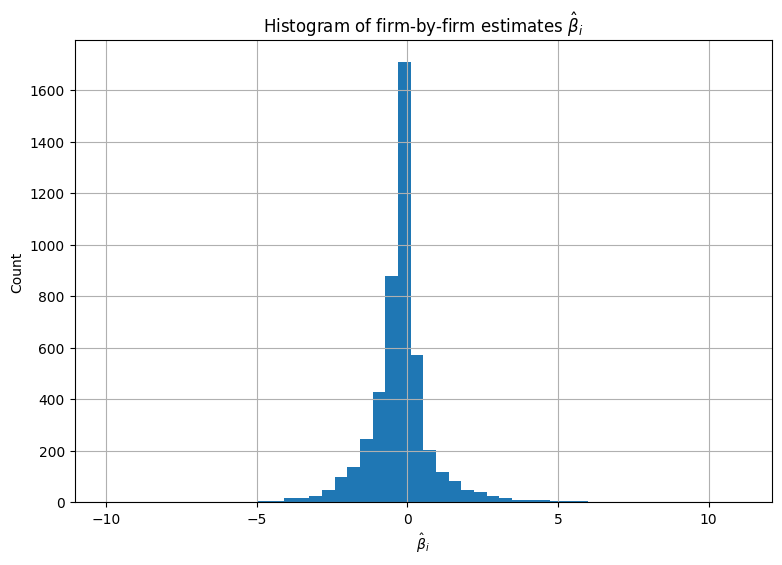

,Mean,Median,Min,Max,N_firms
0,-0.218445,-0.149708,-9.99194,11.047924,4806


In [126]:
betas_dict = {}
for gvkey, g in df_reg.groupby("gvkey"):
    g2 = g[[yvar, xvar]].dropna()
    if len(g2) >= 10:
        Xi = sm.add_constant(g2[xvar])
        yi = g2[yvar]
        res_i = sm.OLS(yi, Xi).fit()
        betas_dict[gvkey] = res_i.params[xvar]

betas = pd. Series(betas_dict, name="beta_i")
betas. index. name = "gvkey"

# Histogram
plt.figure(figsize=(9,6))
plt.hist(betas, bins=50)
plt.title("Histogram of firm-by-firm estimates $\\hat{\\beta}_i$")
plt.xlabel("$\\hat{\\beta}_i$")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Table summary
beta_summary = pd.DataFrame({
    "Mean": [betas.mean()],
    "Median": [betas.median()],
    "Min": [betas.min()],
    "Max": [betas.max()],
    "N_firms": [betas.notna().sum()]
})

beta_summary

##### e. Divide the firms into 4 groups depending on their market value. Create a similar table that contains the same summary statistics for each subsample obtained by dividing the sample of firms into these groups. Comment your results. Hint: make sure to divide the sample using entire firms and not particular firm observations, given that βi is firm-specific.

In [127]:
#Average market equity per firm
firm_size = df_eda.groupby("gvkey")["mkt_equity"].mean().dropna()

#Only keep firms that have a beta estimate
common_firms = betas. index.intersection(firm_size.index)
firm_size = firm_size.loc[common_firms]
betas_filtered = betas.loc[common_firms]

#Create quartiles
size_q = pd.qcut(firm_size, 4, labels=["Q1 (Small)", "Q2", "Q3", "Q4 (Large)"])

#Build dataframe
beta_df = pd.DataFrame({
    "beta_i": betas_filtered,
    "size_quartile": size_q
})

#Summary stats by quartile
group_stats = beta_df.groupby("size_quartile")["beta_i"].agg(
    ["mean", "median", "min", "max", "count"]
)
print(group_stats)

                   mean    median       min        max  count
size_quartile                                                
Q1 (Small)    -0.213263 -0.134509 -9.991940   7.706183   1183
Q2            -0.131275 -0.077085 -7.518590  11.047924   1183
Q3            -0.252362 -0.153409 -6.930518   8.654350   1183
Q4 (Large)    -0.312937 -0.310767 -8.203435   9.730924   1183


/var/folders/qc/ljr9srnn3z5bgt8mf5mk1fjw0000gn/T/ipykernel_16558/2594280233.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = beta_df.groupby("size_quartile")["beta_i"].agg(




## **3. Bankruptcies in Compustat**


#### 3.1 Isolate the companies in the raw, non-winsorized, data.  Create a table with the yearly evolution of the financial ratios for GM and Enron. 

In [128]:
# Reload raw data (non-winsorized)
df_raw = pd.read_csv('HW0.csv')
df_raw = df_raw.drop_duplicates(subset=["gvkey", "fyear"])

# Search for General Motors and Enron by company name
gm = df_raw[df_raw["conm"]. str.contains("GENERAL MOTORS", case=False, na=False)]
enron = df_raw[df_raw["conm"].str.contains("ENRON", case=False, na=False)]

# Function to compute financial ratios (raw data)
def compute_ratios_raw(df):
    df = df.copy()
    df = df.sort_values(["gvkey", "fyear"])
    
    # Lagged variables
    df["lat"] = df.groupby("gvkey")["at"].shift(1)
    df["lprice"] = df.groupby("gvkey")["prcc_f"].shift(1)
    
    # Compute ratios
    df["book_leverage_1"] = (df["dlc"] + df["dltt"]) / df["at"]
    df["mkt_equity"] = df["csho"] * df["prcc_f"]
    df["market_leverage"] = (df["dlc"] + df["dltt"]) / (
        df["dlc"] + df["dltt"] + df["pstk"]. fillna(0) + df["mkt_equity"]
    )
    df["capex_ratio"] = df["capx"] / df["at"]
    df["asset_growth"] = df["at"] / df["lat"] - 1
    df["roe"] = df["ni"] / df["ceq"]
    df["interest_coverage"] = df["ebit"] / df["xint"]
    df["profitability"] = df["oibdp"] / df["at"]
    df["total_payout"] = (df["dv"] + df["prstkc"]) / df["ni"]
    df["dividend_yield"] = (df["dv"] / df["csho"]) / df["lprice"]
    df["profit_margin"] = df["ni"] / df["sale"]
    
    return df

gm_ratios = compute_ratios_raw(gm)
enron_ratios = compute_ratios_raw(enron)


# List of ratios to display
ratios_list = [
    "fyear", "book_leverage_1", "market_leverage", "mkt_equity", 
    "capex_ratio", "asset_growth", "roe", "interest_coverage", 
    "profitability", "total_payout", "dividend_yield", "profit_margin"
]

# Table for General Motors
gm_table = gm_ratios[ratios_list]. sort_values("fyear")
gm_table = gm_table.set_index("fyear")
print("GENERAL MOTORS CORP")
gm_table.round(4)

GENERAL MOTORS CORP


,book_leverage_1,market_leverage,mkt_equity,capex_ratio,asset_growth,roe,interest_coverage,profitability,total_payout,dividend_yield,profit_margin
fyear,,,,,,,,,,,
1995,0.3866,0.6783,39815.2980,0.0872,NaN,0.2947,2.4848,0.1154,0.4372,NaN,0.0416
1995,0.4733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,0.4672,NaN,NaN,NaN,0.1555,NaN,NaN,NaN,NaN,NaN,NaN
1996,0.3868,0.6707,42181.5650,0.1280,0.0231,0.2119,1.4904,0.0908,0.3589,0.0382,0.0310
1997,0.4100,0.6902,42127.4520,0.1372,0.0304,0.3826,1.9439,0.1055,0.8936,0.0419,0.0397
1997,NaN,NaN,NaN,NaN,0.4946,NaN,NaN,NaN,NaN,NaN,NaN
1998,0.4444,0.7093,46874.0100,0.1288,0.1245,0.1973,1.3762,0.0838,1.5145,0.0349,0.0186
1998,NaN,NaN,NaN,NaN,0.4463,NaN,NaN,NaN,NaN,NaN,NaN
1999,0.4801,0.7455,45023.5098,0.1112,0.0674,0.2907,1.9917,0.1010,0.8725,0.0308,0.0344


**Interpretation:**

As you can see, between the  late 1990s and early 2000s, GM was huge with a market value of 40 to 47 billon dollars,  the book leverage around 0.38–0.50 and the  market leverage was above 0.68. The problem was that GM's profit margins were very thin , and its return on equity started falling after 2000. The company kept paying dividends and buying back shares, but it didn't have much room to handle problems if things went wrong. Starting around 2004, GM's finances got much worse. By 2005, the company was actually losing money with a ROE  of −0.72, interest coverage hit − 0.23, and market value collapsed from 42 billion dollars to 10 billion dollars.

From 2006 to 2008, GM lost huge amounts of money, profit margins hit −0.21, and the stock market basically gave up on the company . Unfortunatly, even though GM was in serious trouble, it kept its high debt and continued paying shareholders for a long time, which made everything worse. These sequential deteriorations violated the Conditional Mean Independence (CMI) assumption where the error term becomes systematically correlated with observable distress indicators. However, by using panel data methods with firm fixed effects,the  we can separate the firm's stable characteristics (like  omanagement style) from the actual operational deterioration. It will explain  how changes in profitability directly caused changes in leverage decisions and the true trajectory of the company's financial decline.

When GM went bankrupt in 2009. but after GM Motors emerged from bankruptcy in 2010 things turned around completely: debt dropped way down (book leverage fell to 0.08–0.12), profitability came back (ROE recovered to 0.20–0.33), and the company could easily pay its interest with coverage ratios of 4–8x. 

In [129]:
# Table for Enron
enron_table = enron_ratios[ratios_list]. sort_values("fyear")
enron_table = enron_table.set_index("fyear")
print("ENRON CORP")
enron_table.round(4)

ENRON CORP


,book_leverage_1,market_leverage,mkt_equity,capex_ratio,asset_growth,roe,interest_coverage,profitability,total_payout,dividend_yield,profit_margin
fyear,,,,,,,,,,,
1995,0.2315,0.2398,9578.6012,0.0552,NaN,0.1716,2.0508,0.0793,0.6137,NaN,0.0566
1995,0.0000,0.0000,518.8676,0.0000,NaN,0.1975,inf,0.0181,0.4880,NaN,3.4912
1996,0.2075,0.2312,11002.2225,0.0530,0.2189,0.1629,2.4126,0.0721,NaN,0.0289,0.0439
1996,0.1784,0.0852,658.5840,0.0000,0.8317,0.1733,2.6603,0.0142,0.4563,0.0346,4.0855
1997,0.2670,0.3236,12936.0052,0.0603,0.4514,0.0191,1.8854,0.0593,7.3905,0.0264,0.0052
1998,0.2507,0.2790,18880.8971,0.0649,0.2531,0.1016,2.3360,0.0772,NaN,0.0301,0.0225
1999,0.2442,0.1989,31707.1356,0.0708,0.1373,0.1058,1.7507,0.0633,NaN,0.0115,0.0223
2000,0.1562,0.1385,62479.0775,0.0363,0.9623,0.0946,2.2295,0.0429,NaN,0.0157,0.0097


**Interpretation Enron:**

We can observe that Enron's financial ratios look suprisingly good: the book leverage is low (0.23–0.27 through the 1990s), as well as the  market leverage  (0.24–0.32), and market capitalization is between 9 to 62 billion, which show a good performance .  Moreover, the return on equity is positive, profit margins are reasonable (0.57–4.49%), and the company is  profitable .with a good the interest coverage is strong (2.05–2.66).  

However, why the company with such good performance went bankrupt in 2001? Simply because theses performances were fabricated. In fact,  Enron filed for bankruptcy in December 2001, because the fraud was discovered and exposed overnight. The fake numbers  don't tell you the truth about the company's real financial health, meaning you can't spot the distress coming by looking at the ratios, and if you put Enron data into a regression before it collapsed, you'd be feeding your model completely false numbers that would give you garbage results. 

Actually, we can spot some redflags about their ratios. Actually, the book leverage and  market leverage are  very low despite the company reporting strong profitability (ROE of 0.17–0.45, profit margins sometimes hitting 4.49%), which is counterintuitive, because  profitable companies normally borrow more. Thus,  this combination suggests either profitability is inflated or debt is consider in the balance sheet. as special entities. Also, profit margins also was really volatile (0.57% to 4.49% to 0.06% to 0.52%), which is odd for a stable energy company. In addition, Enron's fraud fundamentally violated Conditional Mean Independence by  manipulating profitability through mark-to-market accounting and entities. This represents unobservable omitted variable bias where fraudulent practices, hidden debt, and management conflicts were correlated with regressors but entirely invisible to external analysts. Unlike General motors, no econometric technique could recover causal relationships from Enron's corrupt data generation process. Unlike General motors, there is no statistical method that could extract the  causal relationships from Enron's  fake financial data because it was intentionally fabricated from the starté



#### 3.2 What happens before, during, and after the fiscal year in which the companies went bankrupt?  How did the financial ratios evolve?


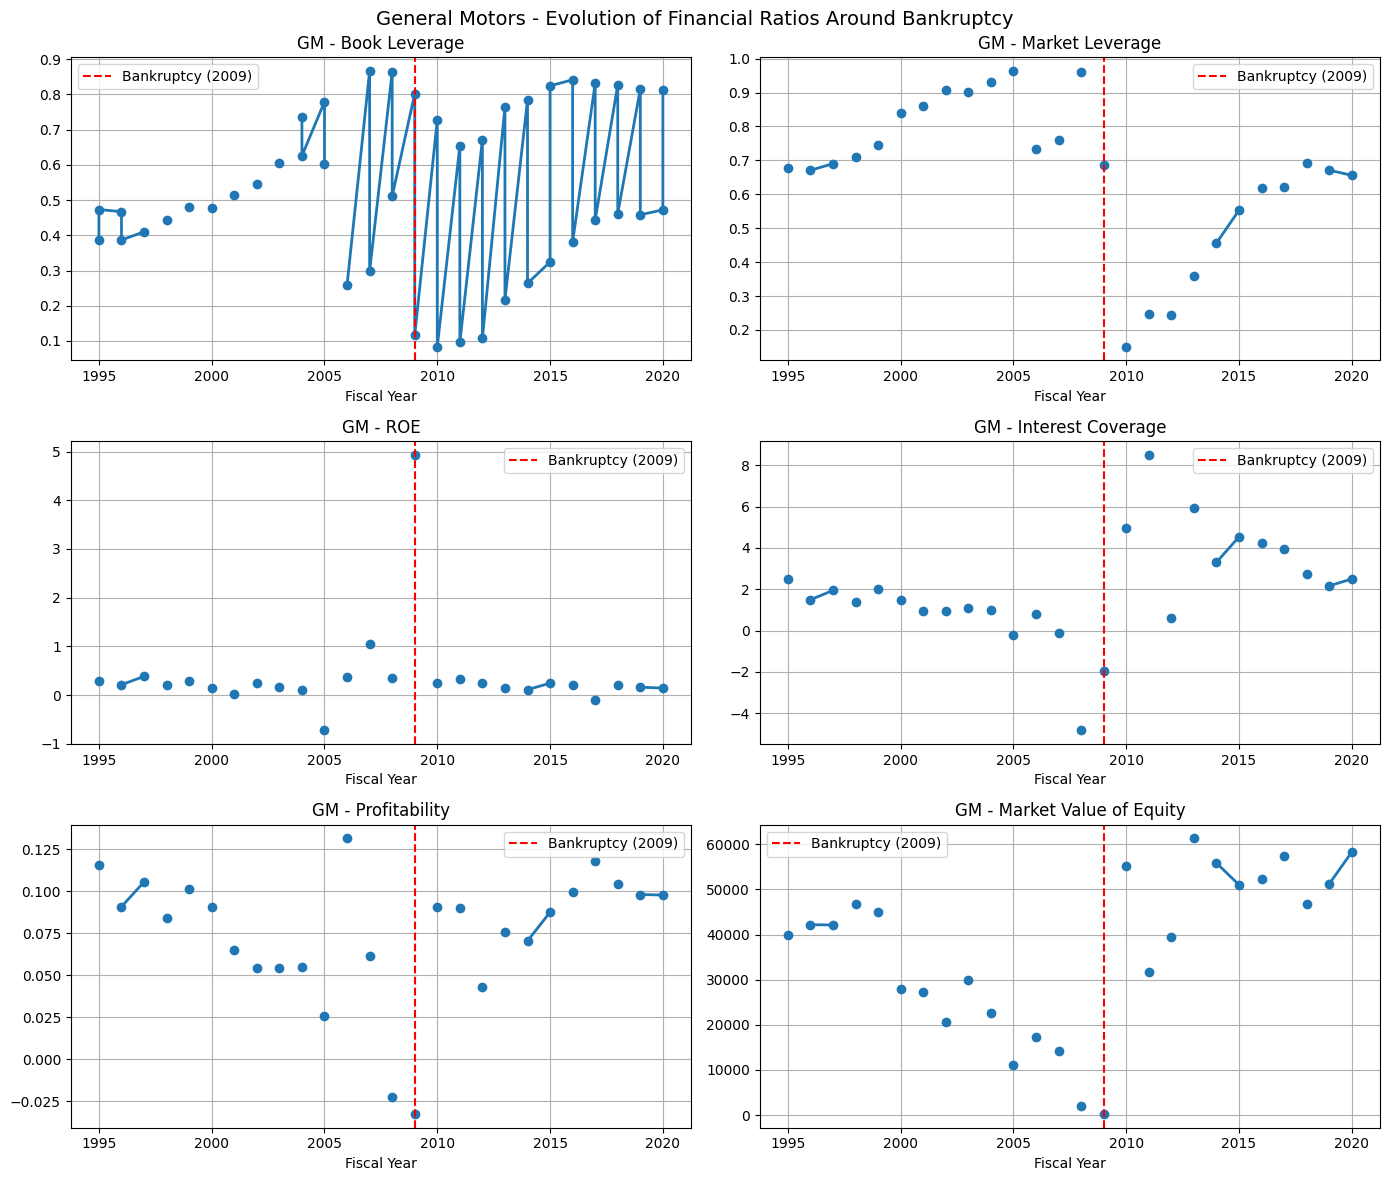

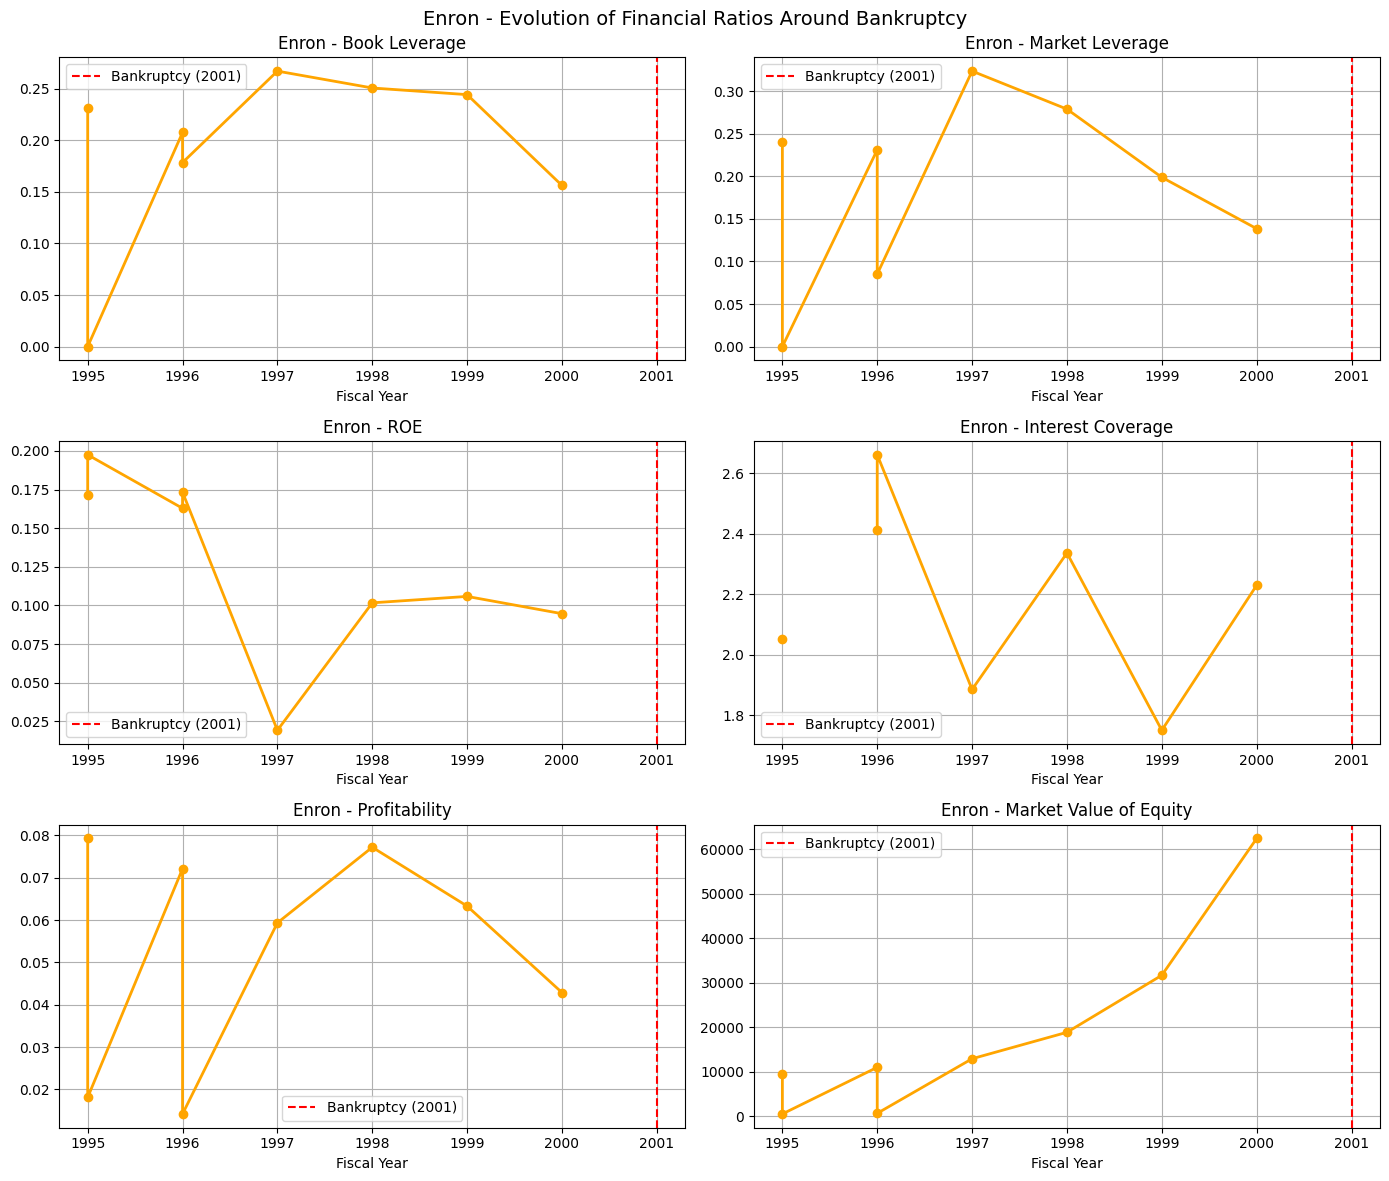

In [130]:
# key ratios evolution for GM (bankruptcy in 2009)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Book Leverage
axes[0, 0].plot(gm_table.index, gm_table["book_leverage_1"], marker='o', linewidth=2)
axes[0, 0].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[0, 0]. set_title("GM - Book Leverage")
axes[0, 0].set_xlabel("Fiscal Year")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Market Leverage
axes[0, 1].plot(gm_table. index, gm_table["market_leverage"], marker='o', linewidth=2)
axes[0, 1].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[0, 1].set_title("GM - Market Leverage")
axes[0, 1]. set_xlabel("Fiscal Year")
axes[0, 1].legend()
axes[0, 1].grid(True)

# ROE
axes[1, 0].plot(gm_table.index, gm_table["roe"], marker='o', linewidth=2)
axes[1, 0].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[1, 0].set_title("GM - ROE")
axes[1, 0].set_xlabel("Fiscal Year")
axes[1, 0]. legend()
axes[1, 0]. grid(True)

# Interest Coverage
axes[1, 1].plot(gm_table.index, gm_table["interest_coverage"], marker='o', linewidth=2)
axes[1, 1].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[1, 1].set_title("GM - Interest Coverage")
axes[1, 1]. set_xlabel("Fiscal Year")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Profitability
axes[2, 0].plot(gm_table.index, gm_table["profitability"], marker='o', linewidth=2)
axes[2, 0].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[2, 0].set_title("GM - Profitability")
axes[2, 0].set_xlabel("Fiscal Year")
axes[2, 0].legend()
axes[2, 0].grid(True)

# Market Equity
axes[2, 1].plot(gm_table. index, gm_table["mkt_equity"], marker='o', linewidth=2)
axes[2, 1].axvline(x=2009, color='red', linestyle='--', label='Bankruptcy (2009)')
axes[2, 1].set_title("GM - Market Value of Equity")
axes[2, 1].set_xlabel("Fiscal Year")
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.suptitle("General Motors - Evolution of Financial Ratios Around Bankruptcy", fontsize=14)
plt.tight_layout()
plt.show()

#key ratios evolution for Enron (bankruptcy in 2001)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Book Leverage
axes[0, 0].plot(enron_table.index, enron_table["book_leverage_1"], marker='o', linewidth=2, color='orange')
axes[0, 0].axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[0, 0].set_title("Enron - Book Leverage")
axes[0, 0].set_xlabel("Fiscal Year")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Market Leverage
axes[0, 1].plot(enron_table.index, enron_table["market_leverage"], marker='o', linewidth=2, color='orange')
axes[0, 1]. axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[0, 1].set_title("Enron - Market Leverage")
axes[0, 1].set_xlabel("Fiscal Year")
axes[0, 1]. legend()
axes[0, 1]. grid(True)

# ROE
axes[1, 0].plot(enron_table.index, enron_table["roe"], marker='o', linewidth=2, color='orange')
axes[1, 0].axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[1, 0].set_title("Enron - ROE")
axes[1, 0].set_xlabel("Fiscal Year")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Interest Coverage
axes[1, 1].plot(enron_table.index, enron_table["interest_coverage"], marker='o', linewidth=2, color='orange')
axes[1, 1].axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[1, 1].set_title("Enron - Interest Coverage")
axes[1, 1].set_xlabel("Fiscal Year")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Profitability
axes[2, 0]. plot(enron_table.index, enron_table["profitability"], marker='o', linewidth=2, color='orange')
axes[2, 0].axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[2, 0].set_title("Enron - Profitability")
axes[2, 0].set_xlabel("Fiscal Year")
axes[2, 0]. legend()
axes[2, 0]. grid(True)

# Market Equity
axes[2, 1].plot(enron_table.index, enron_table["mkt_equity"], marker='o', linewidth=2, color='orange')
axes[2, 1].axvline(x=2001, color='red', linestyle='--', label='Bankruptcy (2001)')
axes[2, 1].set_title("Enron - Market Value of Equity")
axes[2, 1].set_xlabel("Fiscal Year")
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.suptitle("Enron - Evolution of Financial Ratios Around Bankruptcy", fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation:**

**General Motors:**

Before bankruptcy: We can see that the difference is drastic and evident. From 1995 through the early 2000s, book leverage climbed steadily from 0.38 to 0.73, and market leverage similarly rose from 0.68 to 0.94, indicating a clear upward trend of increasing debt load. ROE started healthy (0.30–0.38) but then started declining in 2004–2005, eventually collapsing around 2008–2009. Also, profitability declined starting around 0.10 in the mid-1990s and reduced to near-zero by 2005 and negative by 2008. However, the worst part is that interest coverage stayed approximately positive at 1.5–2.5 through the early 2000s, but then plummeted, turning negative by 2005 and reaching −4.83 by 2008, meaning the company couldn't cover its interest expenses from operating income. Finally, market value went from 40 billion dollars to 2 billion dollars by 2008 as the stock market priced in the firm's distress.

During Bankruptcy: Both leverage and profitability metrics show extreme spikes and inconsistencies, such as ROE spiking to 5, which is accounting garbage. In fact, the raw numbers are economically meaningless because of the restructuring (write-downs, debt forgiveness, new equity injections).

After bankruptcy: Book leverage drops to 0.08 and market leverage to 0.15. However, profitability recovers at around 0.05–0.12, ROE stabilizes at 0.15–0.35, interest coverage bounces back to 2–8x, and market capitalization recovers to 30–60 billion dollars. The charts finally show that the firm is profitable and sustainable with good consistency.


**Enron:**

Before bankruptcy: Suspiciously, Enron showed almost no warning signs in the ratios, which is the main problem. Book leverage started from near zero in 1995, then bumped up gradually to 0.26 by 1997, staying in that range through 2000. Market leverage followed the same pattern, starting at nearly zero and rising only to 0.32 by 1997. ROE was actually very high early on at 0.20 in 1995–1996, then fell to near-zero by 1997 and stayed weak at 0.10 through 2000. However  this didn't alarm the market because Enron's market value of equity kept skyrocketing from 10 billion dollars in 1995 to 62 billion dollars, making investors believe the company had amazing growth potential. Moreover, profitability and interest coverage both declined and became erratic throughout the late 1990s. At the end of the day, the fraud worked because the leverage numbers were ridiculously low, the market capitalization was inflated by the stock price, and the profitability numbers were manipulated. Even looking at the "before bankruptcy" numbers, it is difficult to figure out that the company was in a tough spot.

During bankruptcy: Enron's numbers simply vanish or become meaningless because of the fraud exposure. Thus, the company essentially ceased to exist in any normal sense.

After bankruptcy: There is no data because the company dissolved.

#### 3.4 Using the winsorized data for all firms, compute the standard deviation of the financial ratios for each firm with at least 5 years of non-missing observations.  Create a table by industry. 


In [131]:
# Create industry classification according to Table 2
def classify_industry(sic):
    try:
        sic = int(sic)
    except:
        return np.nan
    if 100 <= sic <= 999:
        return "Agriculture, Forestry and Fishing"
    elif 1000 <= sic <= 1499:
        return "Mining"
    elif 1500 <= sic <= 1799:
        return "Construction"
    elif 2000 <= sic <= 3999:
        return "Manufacturing"
    elif 4000 <= sic <= 4999:
        return "Transportation & Public Utilities"
    elif 5000 <= sic <= 5199:
        return "Wholesale Trade"
    elif 5200 <= sic <= 5999:
        return "Retail Trade"
    elif 6000 <= sic <= 6799:
        return "Finance, Insurance and Real Estate"
    elif 7000 <= sic <= 8999:
        return "Services"
    else:
        return np.nan

df_analysis = df_us. copy()
df_analysis["industry"] = df_analysis["sic"]. apply(classify_industry)

# Drop firms not in the 9 industries
df_analysis = df_analysis[df_analysis["industry"].notna()]

print(f"Number of observations after industry filtering: {len(df_analysis)}")
print(f"Industries present: {df_analysis['industry'].nunique()}")

# Variables for which to compute standard deviation
vars_std = [
    "book_leverage_1_w",
    "market_leverage_w",
    "dividend_yield_w",
    "dividend_payout_w",
    "total_payout_w"
]

# Function to compute standard deviation per firm (min 5 obs)
def firm_std(group, var, min_obs=5):
    valid = group[var].dropna()
    if len(valid) >= min_obs: 
        return valid. std()
    return np.nan

# Compute standard deviation for each firm
firm_stds = []
for gvkey, g in df_analysis. groupby("gvkey"):
    row = {"gvkey": gvkey, "industry": g["industry"].iloc[0]}
    for var in vars_std: 
        row[var + "_std"] = firm_std(g, var)
    firm_stds.append(row)

firm_std_df = pd. DataFrame(firm_stds)

# Drop firms without any computed std
std_cols = [v + "_std" for v in vars_std]
firm_std_df = firm_std_df.dropna(subset=std_cols, how="all")

print(f"Number of firms with at least one std computed: {len(firm_std_df)}")


# Create table:  mean and std of firm-level stds by industry
industry_stats = firm_std_df. groupby("industry")[std_cols].agg(["mean", "std"])

# Rename columns for clarity
industry_stats.columns = ['_'.join(col).strip() for col in industry_stats.columns. values]

# Create cleaner column names
rename_dict = {}
for var in vars_std: 
    rename_dict[var + "_std_mean"] = var. replace("_w", "").replace("_", " ").title() + " (Mean)"
    rename_dict[var + "_std_std"] = var.replace("_w", "").replace("_", " ").title() + " (Std)"

industry_stats = industry_stats.rename(columns=rename_dict)

print("=== Firm-Level Standard Deviation Statistics by Industry ===")
industry_stats.round(4)

# More readable version with separate tables for Mean and Std
mean_cols = [c for c in industry_stats.columns if "(Mean)" in c]
std_cols_display = [c for c in industry_stats. columns if "(Std)" in c]

print("\n=== Mean of Firm-Level Standard Deviations by Industry ===")
print(industry_stats[mean_cols].round(4).to_string())

print("\n=== Std of Firm-Level Standard Deviations by Industry ===")
print(industry_stats[std_cols_display]. round(4).to_string())

Number of observations after industry filtering: 222769
Industries present: 9
Number of firms with at least one std computed: 12600
=== Firm-Level Standard Deviation Statistics by Industry ===

=== Mean of Firm-Level Standard Deviations by Industry ===
                                    Book Leverage 1 (Mean)  Market Leverage (Mean)  Dividend Yield (Mean)  Dividend Payout (Mean)  Total Payout (Mean)
industry                                                                                                                                              
Agriculture, Forestry and Fishing                   0.2432                  0.1438                 0.0112                  0.2965               0.7334
Construction                                        0.2237                  0.1630                 0.0087                  0.1803               0.6094
Finance, Insurance and Real Estate                  0.1398                  0.1298                 0.0150                  0.5042              

**Interpretation:**

**High Volatility:**
 
Manufacturing, Mining, and Services show the highest standard deviations in book leverage of 0.87, 0.92, and 0.82 respectively. These  firms within these industries have  different leverage strategies.Some borrow a lot, others barely borrow at all. This is due to  capital-intensive industries where some firms are heavily invested in physical assets that requires debt financing while others are leaner or operate differently. 

**Low Volatility:**

Finance, Insurance and Real Estate (FIRE) has the lowest mean book leverage (0.14) and relatively moderate standard deviation (0.42).  These firms operate in a more standardized environment where leverage is constrained by regulation. In fact,  Banks, insurance companies, and REITs requires all regulatory control that keep leverage more stable and predictable.


**Payout Ratios and Risk:**

Finance, Insurance and Real Estate also show the highest mean total payout ratios (1.07) and the highest standard deviation (1.28), meaning  these industries return more cash to shareholders but with a higher volatility. Some years paying out huge amounts, other years cutting payouts. This is riskier for shareholders and more prone to measurement error in empirical studies because payout policy is less stable.


**In summary:** Manufacturing and Mining have the most volatile leverage and payout policies, making causal inference hardest in these industries because firm-specific heterogeneity is highest and the GM bankruptcy illustrates exactly why—distressed firms in these industries may fail not because of their leverage choices but because of underlying competitive problems, yet the high leverage volatility makes it hard to disentangle these effects without careful identification strategies.

**Problems for Empirical Analysis:** 

Industry with a high leverage  creates measurement error bias and violations of CMI. In fact, if you're trying to study how leverage affects investment or profitability in Manufacturing like GM motors, you're dealing with industries that have drastic different capital structures. Some of them have highly leveraged, and some  not, which means the relationship between leverage and returns (like profitability or returns) is influenced by undetectable factors that determine both leverage choice and performance, such as  management quality, growth strategy, etc. Also, When a firm goes bankrupt after years of high leverage, you can't tell if it was the leverage that caused the bankruptcy or the unobserved competitive disadvantages that led to both high leverage and bankruptcy. 


#### 3.5 Which industries exhibit the most variation in the financial ratios?  What is special about these industries? 

##### Identify industries with the most variation
##### Compute average of mean stds per industry for overall ranking


Industries Ranked by Average Variation Level
industry
Finance, Insurance and Real Estate    0.3715
Transportation & Public Utilities     0.3361
Wholesale Trade                       0.3107
Retail Trade                          0.3059
Agriculture, Forestry and Fishing     0.2856
Mining                                0.2800
Services                              0.2747
Manufacturing                         0.2529
Construction                          0.2370
Name: avg_variation, dtype: float64


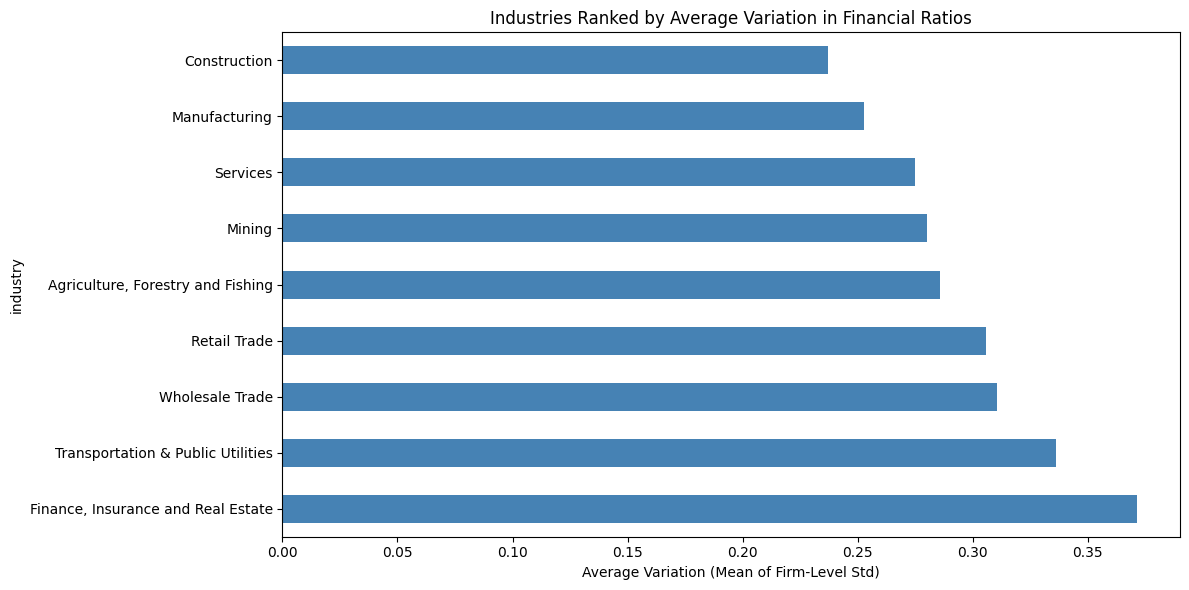

In [132]:
# Identify industries with the most variation
mean_std_cols = [c for c in industry_stats.columns if "(Mean)" in c]
industry_stats["avg_variation"] = industry_stats[mean_std_cols].mean(axis=1)

# Sort by descending variation
ranking = industry_stats["avg_variation"].sort_values(ascending=False)

print("Industries Ranked by Average Variation Level")
print(ranking.round(4))

# Graphics
plt.figure(figsize=(12, 6))
ranking.plot(kind='barh', color='steelblue')
plt.xlabel("Average Variation (Mean of Firm-Level Std)")
plt.title("Industries Ranked by Average Variation in Financial Ratios")
plt.tight_layout()
plt.show()

**Interpretation:**

Finance, Insurance and Real Estate  industries show the highest average variation in financial ratios (0.3715), because while they have lower leverage variation (due to regulation), they have extremely high variation in payout policies: dividend yields, dividend payouts, and total payouts swing wildly across these types of firms. In fact, some pay out 50% or more of earnings while others pay nothing, creating huge instability in shareholder distributions. After that, it is followed by Transportation & Public Utilities (0.3361) and Wholesale Trade (0.3107). 


In contrast,  Manufacturing and Construction rank lower (0.2529 and 0.2370) in overall average variation, because  despite having leverage volatility, their payout policies are actually quite stable and low. Also, these industries prioritize reinvesting profits into operations rather than paying shareholders, so the variation concentrates more  in capital structure rather than distributions. 


In conclusion, the results of variation depend on  industry characteristics: some industries vary in how much they borrow (Manufacturing, Construction), while others vary in how much they pay shareholders (Finance, Insurance and RealEstate,  Utilities). We  need to understandwhat is  actually varying in your data, because different sources of variation create different problems. If you are studying firms where leverage varies a lot, you have to worry that leverage differences reflect unobserved firm needs rather than actual causal effects, while if we are analysing firms where payouts vary a lot, you have to worry that payout differences just reflect how much cash firms have available and whether they can afford to pay shareholders, not deliberate policy choices.

## **4. Properties of OLS Estimator**


#### 4.1. Simulate n = 100 values of xi and εi. Use these values to calculate yi. Estimate the linear regression using OLS and report the resulting estimates.

In [133]:
ALPHA_TRUE = 10.0
BETA_TRUE = 0.5

BASE_SEED = 123
N_REP = 10_000

NS_Q4 = [25, 100, 1000, 10_000]

def ols_simple(y, x):
    xbar = x.mean()
    ybar = y.mean()
    beta_hat = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar) ** 2)
    alpha_hat = ybar - beta_hat * xbar
    return alpha_hat, beta_hat

def draw_x(rng, n):
    return rng.uniform(0.0, 50.0, size=n)

def draw_eps(rng, n, dist):
    if dist == "normal":
        return rng.normal(0.0, 1.0, size=n)
    if dist == "uniform":
        return rng.uniform(-5.0, 5.0, size=n)
    if dist == "poisson_centered":
        return rng.poisson(1.0, size=n) - 1.0
    raise ValueError("dist must be one of: 'normal', 'uniform', 'poisson_centered'")

def simulate_one_dataset(n, seed, eps_dist="normal"):
    rng = np.random.default_rng(seed)
    x = draw_x(rng, n)
    eps = draw_eps(rng, n, eps_dist)
    y = ALPHA_TRUE + BETA_TRUE * x + eps
    return ols_simple(y, x)

def simulate_many_datasets(n, n_rep, seed, eps_dist="normal"):
    rng = np.random.default_rng(seed)
    alpha_hats = np.empty(n_rep, dtype=float)
    beta_hats = np.empty(n_rep, dtype=float)
    for i in range(n_rep):
        x = draw_x(rng, n)
        eps = draw_eps(rng, n, eps_dist)
        y = ALPHA_TRUE + BETA_TRUE * x + eps
        alpha_hats[i], beta_hats[i] = ols_simple(y, x)
    return alpha_hats, beta_hats

def summary_stats(arr):
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr, ddof=1)),
        "median": float(np.median(arr)),
        "min": float(np.min(arr)),
        "max": float(np.max(arr)),
    }

def print_stats_table(alpha_hats, beta_hats):
    a = summary_stats(alpha_hats)
    b = summary_stats(beta_hats)

    headers = ["", "mean", "std", "median", "min", "max"]
    rows = [
        ["alpha_hat", a["mean"], a["std"], a["median"], a["min"], a["max"]],
        ["beta_hat",  b["mean"], b["std"], b["median"], b["min"], b["max"]],
    ]

    col_widths = [max(len(headers[i]), 10) for i in range(len(headers))]
    col_widths[0] = max(len(rows[0][0]), len(rows[1][0]), len(headers[0]), 10)

    def fmt(x):
        if isinstance(x, (int, float)):
            return f"{x:.6f}"
        return str(x)

    line = " | ".join(str(headers[i]).ljust(col_widths[i]) for i in range(len(headers)))
    print(line)
    print("-" * len(line))
    for r in rows:
        out = []
        out.append(str(r[0]).ljust(col_widths[0]))
        for j in range(1, len(headers)):
            out.append(fmt(r[j]).rjust(col_widths[j]))
        print(" | ".join(out))

def plot_hist_single(arr, true_value, title, xlabel, bins=40):
    plt.figure(figsize=(8, 5))
    plt.hist(arr, bins=bins, density=True)
    plt.axvline(true_value, linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.show()

def plot_hist_2x2_by_n(series_by_n, true_value, suptitle, xlabel, bins=40):
    fig, axes = plt.subplots(2, 2, figsize=(11, 7), constrained_layout=True)
    axes = axes.ravel()
    for ax, n in zip(axes, NS_Q4):
        arr = series_by_n[n]
        ax.hist(arr, bins=bins, density=True)
        ax.axvline(true_value, linestyle="--", linewidth=2)
        ax.set_title(f"n = {n}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Density")
    fig.suptitle(suptitle)
    plt.show()
n = 100
seed_q1 = BASE_SEED + 100

alpha_hat_q1, beta_hat_q1 = simulate_one_dataset(
    n=n,
    seed=seed_q1,
    eps_dist="normal"
)

print("Q1 (n=100) OLS estimates:")
print("alpha_hat =", alpha_hat_q1)
print("beta_hat  =", beta_hat_q1)


Q1 (n=100) OLS estimates:
alpha_hat = 9.92724614860024
beta_hat  = 0.5005043860704959


#### 4.2. Repeat step 1 N = 10, 000 times, that is, simulate N = 10, 000 datasets and for each dataset estimate the model using OLS. Save the resulting estimates bαi and bβi.

In [134]:
n = 100
seed_q2 = BASE_SEED + 200

alpha_hats_q2, beta_hats_q2 = simulate_many_datasets(
    n=n,
    n_rep=N_REP,
    seed=seed_q2,
    eps_dist="normal"
)
print("alpha_hats shape:", alpha_hats_q2.shape)
print("beta_hats shape :", beta_hats_q2.shape)

print("First 5 alpha_hats:", alpha_hats_q2[:5])
print("First 5 beta_hats :", beta_hats_q2[:5])

print("Mean alpha_hat:", alpha_hats_q2.mean())
print("Mean beta_hat :", beta_hats_q2.mean())



alpha_hats shape: (10000,)
beta_hats shape : (10000,)
First 5 alpha_hats: [ 9.93834318 10.18094176  9.88902342 10.05735214  9.99953012]
First 5 beta_hats : [0.50072035 0.49199417 0.5072106  0.49796166 0.497909  ]
Mean alpha_hat: 9.99915694935018
Mean beta_hat : 0.5000189461101916


#### 4.3. Plot the histogram of the resulting estimates of αi and βi. Create a table with the mean, the standard deviation, the median, the minimum, and the maximum of each estimate for α and β. What do you observe? What does this tell us about the OLS estimator?

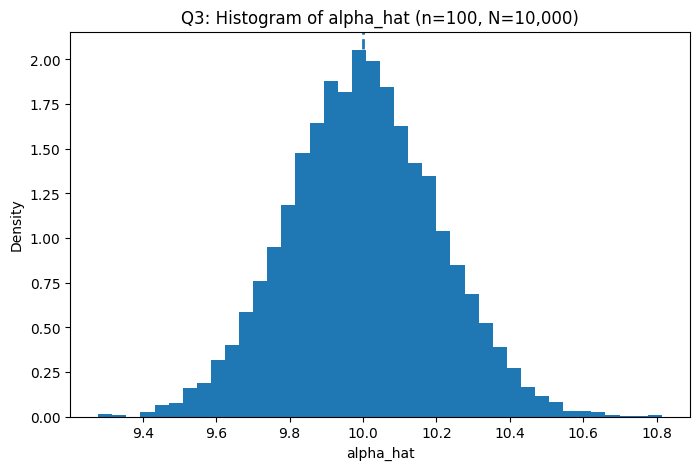

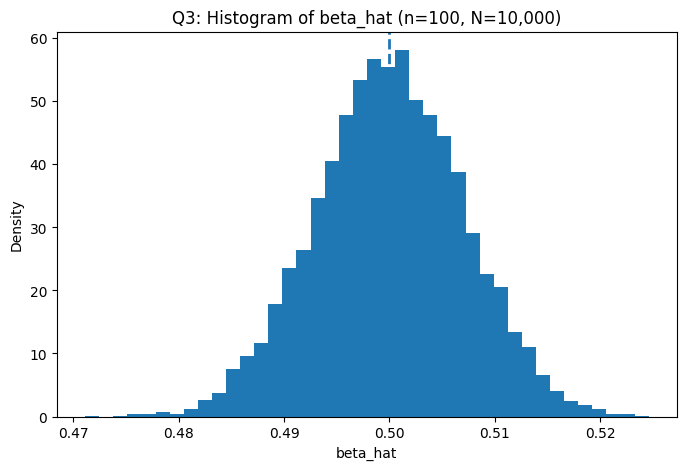

Q3 summary table (n=100, N=10,000):
           | mean       | std        | median     | min        | max       
---------------------------------------------------------------------------
alpha_hat  |   9.999157 |   0.204166 |   9.997270 |   9.278489 |  10.814215
beta_hat   |   0.500019 |   0.007053 |   0.500022 |   0.471118 |   0.524594


In [135]:
plot_hist_single(
    alpha_hats_q2,
    true_value=ALPHA_TRUE,
    title="Q3: Histogram of alpha_hat (n=100, N=10,000)",
    xlabel="alpha_hat"
)

plot_hist_single(
    beta_hats_q2,
    true_value=BETA_TRUE,
    title="Q3: Histogram of beta_hat (n=100, N=10,000)",
    xlabel="beta_hat"
)

print("Q3 summary table (n=100, N=10,000):")
print_stats_table(alpha_hats_q2, beta_hats_q2)



4. Repeat points 1 and 2 by using n = {25, 100, 1000, 10000}. Plot the four histograms in a
single graph. What do you observe? What does this tell us about the OLS estimator?

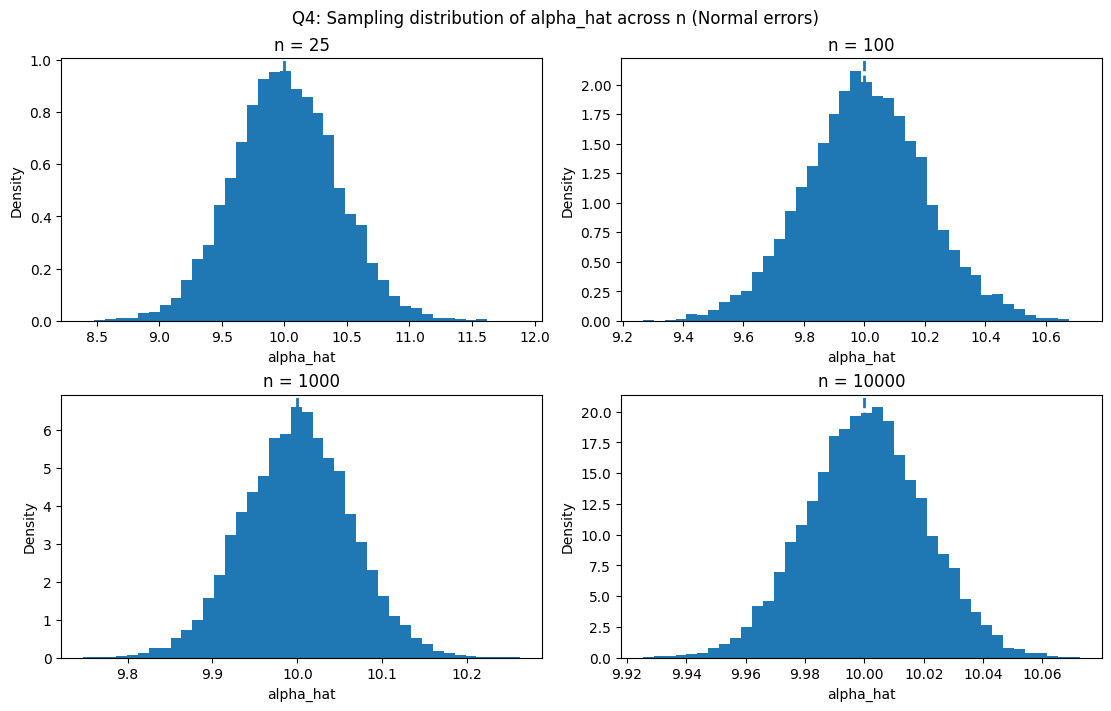

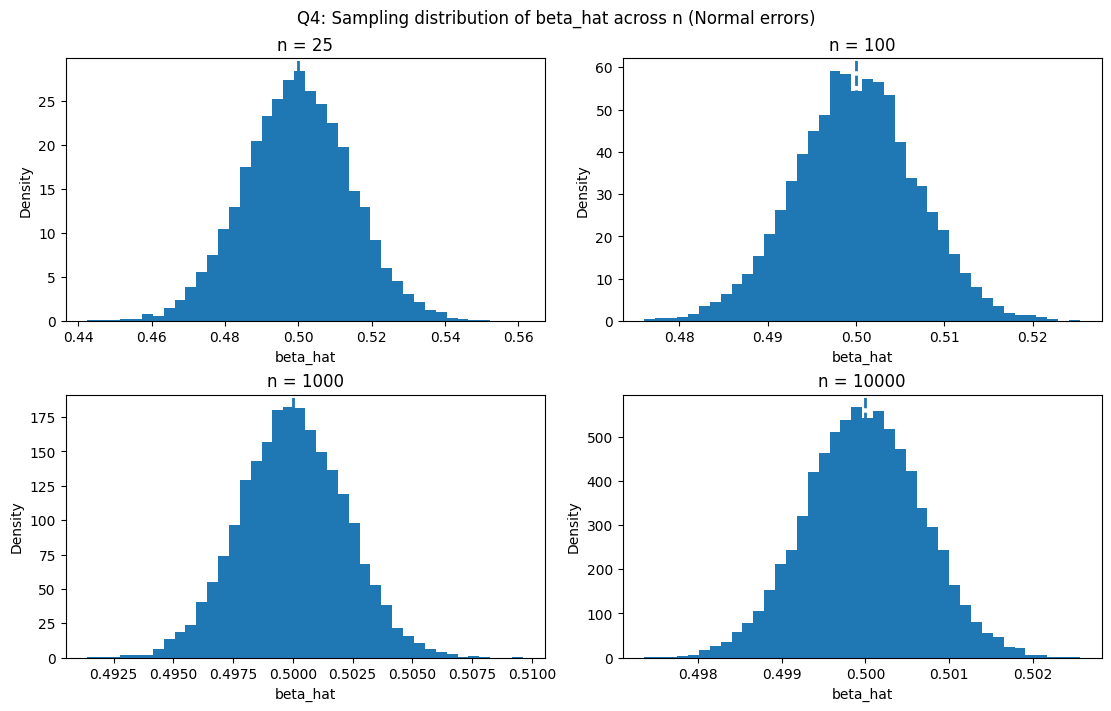

In [136]:
seed_base_q4 = BASE_SEED + 400

alpha_by_n_q4 = {}
beta_by_n_q4 = {}

for n in NS_Q4:
    a_hats, b_hats = simulate_many_datasets(
        n=n,
        n_rep=N_REP,
        seed=seed_base_q4 + n,
        eps_dist="normal"
    )
    alpha_by_n_q4[n] = a_hats
    beta_by_n_q4[n] = b_hats

plot_hist_2x2_by_n(
    series_by_n=alpha_by_n_q4,
    true_value=ALPHA_TRUE,
    suptitle="Q4: Sampling distribution of alpha_hat across n (Normal errors)",
    xlabel="alpha_hat"
)

plot_hist_2x2_by_n(
    series_by_n=beta_by_n_q4,
    true_value=BETA_TRUE,
    suptitle="Q4: Sampling distribution of beta_hat across n (Normal errors)",
    xlabel="beta_hat"
)


The sampling distributions of both alpha_hat and beta_hat are centered around their true parameter values for all sample sizes n = 25, 100, 1000, and 10000, indicating that the OLS estimator is unbiased. As the sample size increases, the distributions become increasingly concentrated and symmetric, with a clear reduction in dispersion. In particular, the variance of the estimators decreases monotonically with n, and the mass of the distribution tightens around the true values alpha = 10 and beta = 0.5.

For small samples (n = 25), the sampling distributions are wider and exhibit greater variability, reflecting higher estimation uncertainty. As n grows, the distributions approach a normal shape with sharply reduced spread, illustrating the consistency of the OLS estimator and the convergence of alpha_hat and beta_hat to their true values. These results are fully consistent with the asymptotic properties of OLS under classical assumptions, namely unbiasedness, consistency, and asymptotic normality when errors are i.i.d. with finite variance.

#### 4.5. Repeat points 1, 2 and 4 by by assuming that:
#### (a) εi
#### iid ∼ Uniform[−5, 5]
#### (b) εi
#### iid ∼ Poisson(1) − 1
#### What do you observe? What does this tell us about the OLS estimator?

Q5 (Uniform[-5,5] errors) Point 1 (single dataset, n=100):
alpha_hat = 9.737075839015013
beta_hat  = 0.5081208841717699

Q5 (Uniform[-5,5] errors) Point 2 summary table (n=100, N=10,000):
           | mean       | std        | median     | min        | max       
---------------------------------------------------------------------------
alpha_hat  |   9.999108 |   0.577273 |   9.997373 |   7.858515 |  12.081830
beta_hat   |   0.499937 |   0.019998 |   0.500189 |   0.427192 |   0.576009


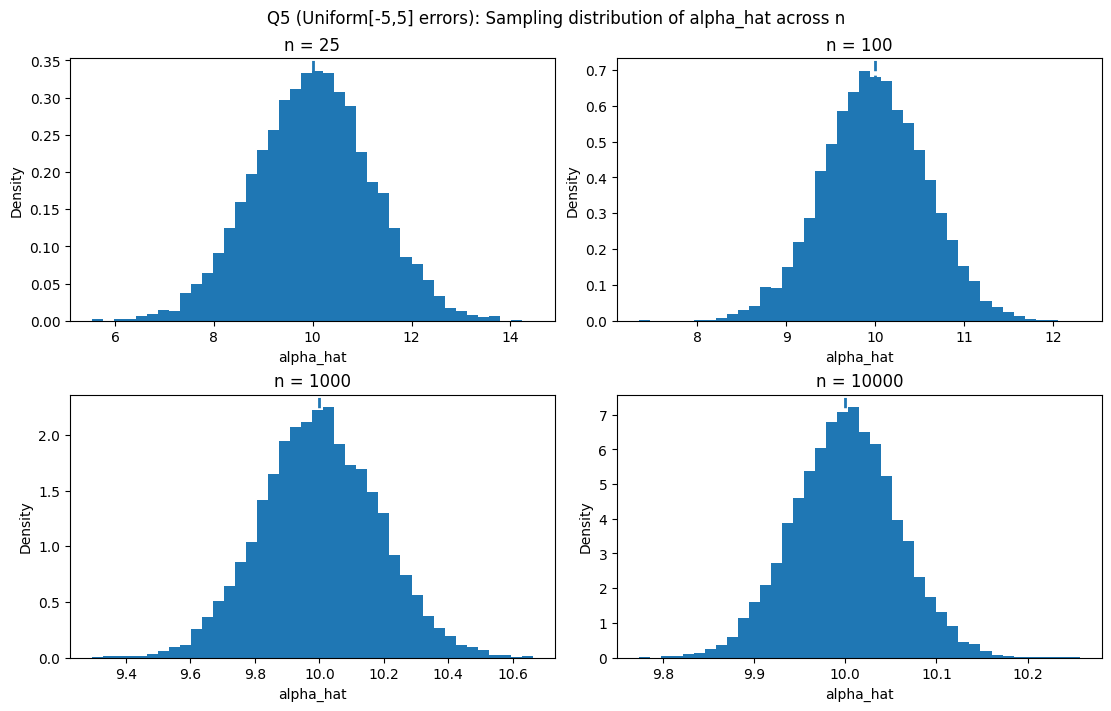

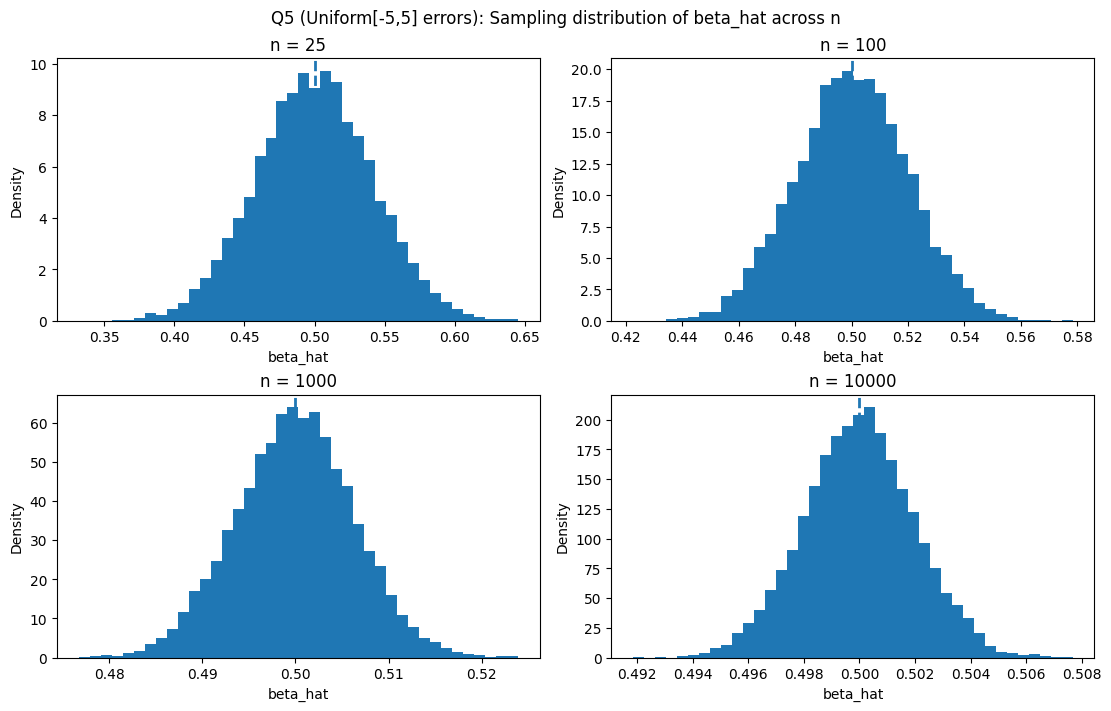

Q5 (Poisson(1)-1 errors) Point 1 (single dataset, n=100):
alpha_hat = 9.880343216299982
beta_hat  = 0.5040532375336748

Q5 (Poisson(1)-1 errors) Point 2 summary table (n=100, N=10,000):
           | mean       | std        | median     | min        | max       
---------------------------------------------------------------------------
alpha_hat  |  10.001437 |   0.202475 |   9.998009 |   9.330589 |  10.788408
beta_hat   |   0.499932 |   0.007019 |   0.500003 |   0.474128 |   0.525913


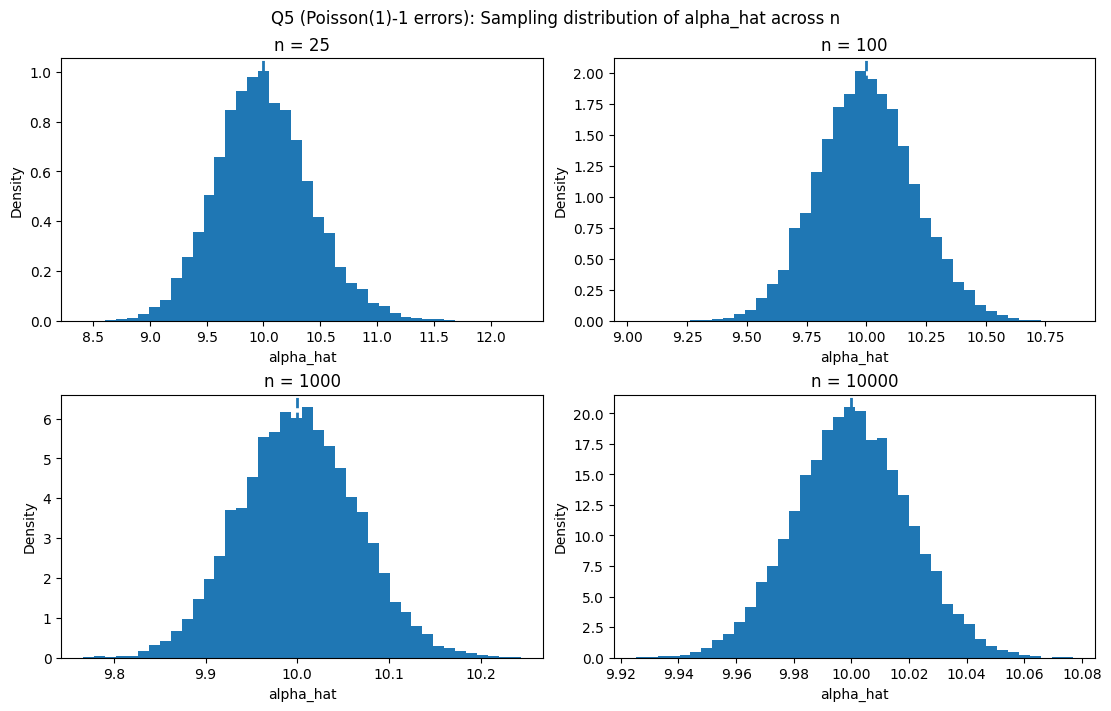

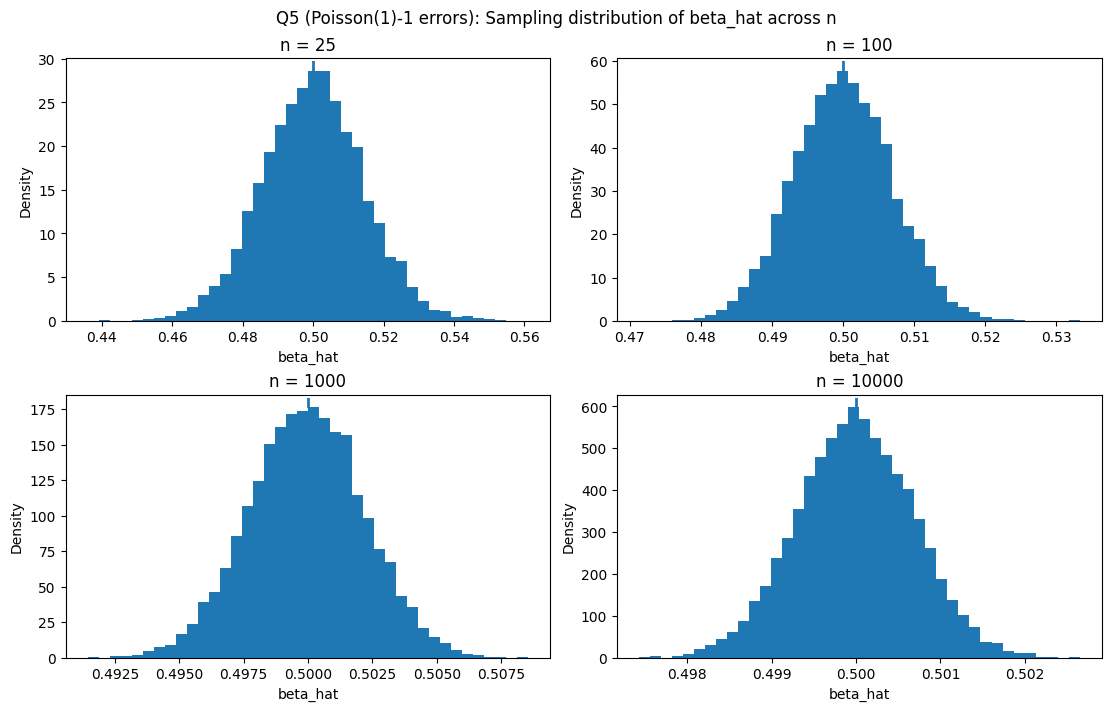

In [137]:
seed_base_q5 = BASE_SEED + 600

def run_q5_for_dist(eps_dist, label):
    alpha_hat_single, beta_hat_single = simulate_one_dataset(
        n=100,
        seed=seed_base_q5 + 1,
        eps_dist=eps_dist
    )

    alpha_hats_100, beta_hats_100 = simulate_many_datasets(
        n=100,
        n_rep=N_REP,
        seed=seed_base_q5 + 2,
        eps_dist=eps_dist
    )

    alpha_by_n = {}
    beta_by_n = {}
    for n in NS_Q4:
        a_hats, b_hats = simulate_many_datasets(
            n=n,
            n_rep=N_REP,
            seed=seed_base_q5 + 10_000 + n,
            eps_dist=eps_dist
        )
        alpha_by_n[n] = a_hats
        beta_by_n[n] = b_hats

    print(f"Q5 ({label}) Point 1 (single dataset, n=100):")
    print("alpha_hat =", alpha_hat_single)
    print("beta_hat  =", beta_hat_single)

    print(f"\nQ5 ({label}) Point 2 summary table (n=100, N=10,000):")
    print_stats_table(alpha_hats_100, beta_hats_100)

    plot_hist_2x2_by_n(
        series_by_n=alpha_by_n,
        true_value=ALPHA_TRUE,
        suptitle=f"Q5 ({label}): Sampling distribution of alpha_hat across n",
        xlabel="alpha_hat"
    )

    plot_hist_2x2_by_n(
        series_by_n=beta_by_n,
        true_value=BETA_TRUE,
        suptitle=f"Q5 ({label}): Sampling distribution of beta_hat across n",
        xlabel="beta_hat"
    )

run_q5_for_dist(eps_dist="uniform", label="Uniform[-5,5] errors")
run_q5_for_dist(eps_dist="poisson_centered", label="Poisson(1)-1 errors")


**Interpretation:**

(a) ε ~ Uniform[−5, 5]
With Uniform[−5,5] errors, the sampling distributions of α̂ and β̂ remain centered near the true parameters across all n, consistent with unbiasedness under exogeneity (E[ε|x]=0). Relative to the Normal case, the finite-sample distributions are slightly wider/flatter because the error variance is larger and the distribution is bounded. As n increases (25 → 10,000), both α̂ and β̂ concentrate sharply around the true values, showing increased precision and convergence to the true parameters. This indicates that OLS remains unbiased and consistent even when errors are non-normal, as long as the standard assumptions (especially mean-zero, independence from x, and finite variance) hold.

(b) ε ~ Poisson(1) − 1
With Poisson(1)−1 errors, disturbances are discrete and skewed, so for small n the sampling distributions of α̂ and β̂ can look less smooth and more asymmetric. Nevertheless, the Monte-Carlo means of α̂ and β̂ stay close to the true parameters, indicating no systematic bias under exogeneity. As n grows, the distributions become tighter and more symmetric, concentrating around the true values. Overall, this shows OLS is robust to non-normality in large samples: non-normal (or discrete/skewed) errors mainly affect the finite-sample shape and variability, not consistency, provided E[ε|x]=0 and Var(ε)<∞.